# Predicción de Ventas Mensuales para Retail con Machine Learning

### Resumen del Proyecto

Este proyecto aborda el desafío de predecir las ventas mensuales para miles de combinaciones de tienda-producto en una cadena de retail. Una predicción precisa es fundamental para optimizar la gestión de inventario, planificar estrategias de precios y maximizar los ingresos.

**Objetivo:** El objetivo técnico es desarrollar un modelo de Machine Learning que minimice el Error Cuadrático Medio (RMSE) en la predicción de ventas para el mes siguiente.

**Metodología:**
El pipeline desarrollado sigue un enfoque robusto y profesional:
1.  **Preprocesamiento y Limpieza de Datos:** Manejo de outliers e imputación jerárquica de valores faltantes.
2.  **Ingeniería de Características Avanzada:** Creación de un amplio conjunto de features para capturar la estacionalidad, tendencias, lags y otras dinámicas temporales.
3.  **Modelado y Validación:** Entrenamiento y evaluación de múltiples modelos de Gradient Boosting (LightGBM, XGBoost, CatBoost) y RandomForest, utilizando una estrategia de validación temporal que simula un entorno de producción.
4.  **Ensembling (Blending):** Construcción de un modelo de ensamble final mediante un meta-modelo Ridge para combinar las fortalezas de los mejores modelos base y mejorar la precisión final.

**Resultado Final:** El ensamble calibrado final alcanzó un **RMSE de validación de 2.6311**, superando a todos los modelos individuales y proporcionando una solución robusta y precisa.

**Porque se ha decidido este tipo de validación del modelo?**
- Tras jugar con varias estrategias de validación (cross validation, ARIMAS, y Prophet en concreto) se ha decidio que por la naturaleza de **nuestros datos***, y debido a que no tenemos suficientes registros en el tiempo como para sacar el máximo partido a la cross validation mantendremos el enfoque inicial planteado en clase: Validar el mes anterior al mes test y el resto considerarlo como conjunto de entrenamiento.

***Naturaleza de nuestros datos:** provienen del agregado, esto se puede apreciar ya que hay combinaciones de items que no tienen registros todos los meses.


## **1.Imports**

In [1]:
# %load_ext cuml.accel
# Para datasets pequeños como es nuestro caso, el utilizar GPU no sale a cuenta debido al overhead de mover los datos a la GPU.

In [2]:
# ==============================================================================
# 1. IMPORTS
# ==============================================================================

# --- Manejo de Datos ---
import os
import pandas as pd
import numpy as np
import warnings

# --- Pipeline y Preprocesamiento ---
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import Pool
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


# --- Modelado ---
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost.callback import EarlyStopping as XGBEarlyStopping

# --- Métricas y Validación ---
from sklearn.metrics import mean_squared_error

# --- Visualización (incluyendo las usadas en celdas comentadas) ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.inspection import permutation_importance


# Ignorar warnings para una presentación más limpia
warnings.filterwarnings("ignore")

from typing import List, Optional, Dict, Tuple

## **2. Configuración y Carga de Datos**

In [3]:
DATA_PATH = r"C:/Users/teser\Desktop/Master-DS-Nucleo-Digital/Time-Series/Monthly sales prediction/kaggle_predict_sales\data/"


TRAIN_FILE = "ts_kaggle_train.csv"


def load_data(path, filename):
    print(f"Cargando datos desde {os.path.join(path, filename)}...")
    df = pd.read_csv(os.path.join(path, filename), index_col=0)
    print("Datos cargados con éxito.")
    return df


raw_df = load_data(DATA_PATH, TRAIN_FILE)
# raw_df=pd.read_csv(TRAIN_FILE)

Cargando datos desde C:/Users/teser\Desktop/Master-DS-Nucleo-Digital/Time-Series/Monthly sales prediction/kaggle_predict_sales\data/ts_kaggle_train.csv...
Datos cargados con éxito.


## **3. Preprocesamiento y Análisis Exploratorio (EDA)**

El primer paso consiste en limpiar y preparar los datos. Se utiliza una clase `HierarchicalImputerPreprocessor` para realizar dos tareas críticas de forma causal (sin fuga de datos):
* **Capping de Outliers:** Se limitan las ventas y precios extremos por categoría para evitar que estos valores anómalos distorsionen el entrenamiento.
* **Imputación de Precios:** Los precios faltantes se imputan de forma jerárquica, utilizando primero el historial del propio producto y, si no existe, la mediana de su categoría.

El análisis exploratorio inicial (ver gráficos en la sección 5.2) reveló patrones clave que guiaron la ingeniería de características, como una **fuerte estacionalidad** (picos en diciembre/enero) y una **relación no lineal entre el precio y las ventas**.

In [ ]:

class HierarchicalImputerPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocesador con imputación jerárquica para precios y capping de outliers.
    1. Imputa precios usando bfill().ffill() por unique_id.
    2. Imputa los nulos restantes con la mediana por categoría (aprendida en fit).
    3. Realiza capping de outliers para ventas y precios.
    """

    def __init__(
        self, sales_iqr_multiplier=1.5, price_iqr_multiplier=1.5, global_sales_cap=30
    ):
        self.sales_iqr_multiplier = sales_iqr_multiplier
        self.price_iqr_multiplier = price_iqr_multiplier
        self.global_sales_cap = global_sales_cap

        # Atributos que se aprenderán en fit()
        self.sales_caps_ = {}
        self.price_caps_ = {}
        self.price_medians_ = {}  # Para la imputación de nivel 2
        self.global_price_median_ = None  # Fallback final

    def fit(self, X, y=None):
        print("🚀 Entrenando HierarchicalImputerPreprocessor...")

        # --- 1. Aprender valores para imputación y capping de precios ---
        self.global_price_median_ = X["monthly_average_price"].median()
        for category in X["item_category_id"].unique():
            mask = X["item_category_id"] == category

            # Aprender mediana de precios por categoría para imputación
            category_price = X.loc[mask, "monthly_average_price"].dropna()
            if not category_price.empty:
                self.price_medians_[category] = category_price.median()

                # Aprender umbral de capping de precios
                Q1_p = category_price.quantile(0.25)
                Q3_p = category_price.quantile(0.75)
                IQR_p = Q3_p - Q1_p
                upper_bound_p = Q3_p + self.price_iqr_multiplier * IQR_p
                self.price_caps_[category] = upper_bound_p

        # --- 2. Aprender umbrales de capping de ventas ---
        for category in X["item_category_id"].unique():
            mask = X["item_category_id"] == category
            category_sales = X.loc[mask, "monthly_sales"].dropna()
            if not category_sales.empty:
                Q1_s = category_sales.quantile(0.25)
                Q3_s = category_sales.quantile(0.75)
                IQR_s = Q3_s - Q1_s
                upper_bound_s = Q3_s + self.sales_iqr_multiplier * IQR_s
                self.sales_caps_[category] = min(upper_bound_s, self.global_sales_cap)

        print(" -> Parámetros de imputación y capping aprendidos.")
        return self

    def transform(self, X):
        print("🚀 Aplicando transformación de HierarchicalImputerPreprocessor...")
        df = X.copy()
        price_col = "monthly_average_price"

        df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

        # --- 1. Imputación Jerárquica de Precios ---
        print(" -> Nivel 1: Imputando precios con bfill().ffill() por unique_id...")
        df[price_col] = df.groupby("unique_id")[price_col].transform(
            lambda s: s.bfill().ffill()
        )

        # --- Nivel 2: Imputar nulos restantes con la mediana de la categoría ---
        if df[price_col].isnull().any():
            print(
                " -> Nivel 2: Imputando nulos restantes con medianas por categoría..."
            )
            # Mapea cada fila a la mediana de su categoría
            category_medians = df["item_category_id"].map(self.price_medians_)
            df[price_col].fillna(category_medians, inplace=True)

        # --- Nivel 3: Fallback final con la mediana global ---
        if df[price_col].isnull().any():
            print(" -> Nivel 3: Imputando nulos restantes con la mediana global...")
            df[price_col].fillna(self.global_price_median_, inplace=True)

        # --- 2. Capping de Outliers de Precios (después de imputar) ---
        print(" -> Aplicando capping a 'monthly_average_price'...")
        df[price_col] = df.groupby("item_category_id")[price_col].transform(
            lambda p: p.clip(0, self.price_caps_.get(p.name, self.global_price_median_))
        )

        # --- 3. Capping de Outliers de Ventas ---
        print(" -> Aplicando capping a 'monthly_sales'...")
        df["monthly_sales"] = df.groupby("item_category_id")["monthly_sales"].transform(
            lambda s: s.clip(0, self.sales_caps_.get(s.name, self.global_sales_cap))
        )

        return df

## **4. Feature Engineering**

Para que los modelos puedan aprender de la historia, es crucial transformar la serie temporal en un formato tabular rico en información. La clase `CoreFeatureEngineer` consolida la creación de un conjunto completo de características causales:

* **Features Temporales:** Mes, año, día del mes y transformaciones cíclicas (seno/coseno) para capturar la estacionalidad.
* **Lag Features:** Ventas y precios de meses anteriores (hace 1, 3, 6 meses) para capturar la auto-correlación.
* **Rolling Windows:** Estadísticas móviles (media, desviación estándar, máximo) sobre ventanas de 3 y 6 meses para suavizar el ruido y capturar tendencias recientes.
* **Features de Dinámica de Precios:** Ratios que comparan el precio actual de un ítem con su media histórica y la media de su categoría.
* **Features "Expertas":** Interacciones categóricas y variables como los "meses desde el último pico de ventas".

In [ ]:

class CoreFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Clase única y completa que consolida toda la lógica de ingeniería de características.
    - Es configurable (peak_threshold).
    - Orquesta la creación de todas las features en el orden correcto y de forma causal.
    - No realiza imputación, delega esa tarea a un paso posterior.
    """

    def __init__(self, target_col="monthly_sales", peak_threshold=25):
        self.target_col = target_col
        self.peak_threshold = peak_threshold
        print(
            f"✅ ComprehensiveFeatureEngineer inicializado. Umbral de pico: {self.peak_threshold}"
        )

    def fit(self, X, y=None):
        # Este transformador es 'stateless', no aprende nada en el fit.
        return self

    def transform(self, X):
        print("\n🚀 Ejecutando Comprehensive Feature Engineering...")
        df = X.copy()

        # --- PRE-PROCESADO ESENCIAL ---
        # Aseguramos el orden causal para que lags, rolling y picos funcionen correctamente.
        df = df.sort_values(["unique_id", "date"])

        # --- NIVEL 1: FEATURES BÁSICAS ---
        df = self._extract_ids(df)
        df = self._add_time_features(df)
        df = self._create_basic_lags_rolling(df)

        # --- NIVEL 2: FEATURES DE TENDENCIA ---
        df = self._add_sales_trend(df)
        df = self._add_price_trend(df)

        # --- NIVEL 3: FEATURES EXPERTAS ---
        df = self._add_volatility_consistency(df)
        df = self._add_market_share(df)
        df = self._add_interaction_features(df)
        df = self._add_causal_peak_features(df)

        # --- NIVEL 4: FEATURES CONTEXTUALES Y AVANZADAS ---
        df = self._add_contextual_interactions(df)
        df = self._add_advanced_rolling_stats(df)
        df = self._add_price_dynamics(df)

        df = self._add_causal_ratios(df)

        # --- POST-PROCESADO FINAL ---
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        print("✅ Ingeniería de características finalizada.")
        return df

    @staticmethod
    def _safe_divide(numerator, denominator):
        denominator = denominator.replace(0, np.nan)
        return numerator / denominator

    def _extract_ids(self, df):
        split_ids = df["unique_id"].str.split("_", expand=True)
        df["shop_id"] = pd.to_numeric(split_ids[0])
        df["item_id"] = pd.to_numeric(split_ids[1])
        return df

    def _add_time_features(self, df):
        df["month"] = df["date"].dt.month
        df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
        df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
        df["year"] = df["date"].dt.year
        df["date_block_num"] = (df["year"] - 2013) * 12 + df["month"] - 1
        df["item_age"] = df.groupby("unique_id").cumcount()
        return df

    def _create_basic_lags_rolling(self, df):
        g_sales = df.groupby("unique_id")["monthly_sales"]
        g_price = df.groupby("unique_id")["monthly_average_price"]
        for lag in [1, 3, 6]:
            df[f"monthly_sales_lag_{lag}"] = g_sales.shift(lag)
            df[f"monthly_average_price_lag_{lag}"] = g_price.shift(lag)
        for window in [3, 6]:
            past_sales = g_sales.shift(1)
            past_price = g_price.shift(1)
            df[f"monthly_sales_rolling_mean_{window}"] = (
                past_sales.groupby(df["unique_id"])
                .rolling(window, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )
            df[f"monthly_sales_rolling_std_{window}"] = (
                past_sales.groupby(df["unique_id"])
                .rolling(window, min_periods=1)
                .std()
                .reset_index(level=0, drop=True)
            )
            df[f"monthly_average_price_rolling_mean_{window}"] = (
                past_price.groupby(df["unique_id"])
                .rolling(window, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )
            df[f"monthly_average_price_rolling_std_{window}"] = (
                past_price.groupby(df["unique_id"])
                .rolling(window, min_periods=1)
                .std()
                .reset_index(level=0, drop=True)
            )
        return df

    def _add_sales_trend(self, df):
        df["sales_trend_3m"] = self._safe_divide(
            df["monthly_sales_lag_1"] - df["monthly_sales_lag_3"],
            df["monthly_sales_lag_3"],
        )
        return df

    def _add_price_trend(self, df):
        df["price_trend_3m"] = self._safe_divide(
            df["monthly_average_price_lag_1"] - df["monthly_average_price_lag_3"],
            df["monthly_average_price_lag_3"],
        )
        return df

    def _add_volatility_consistency(self, df):
        past_sales = df.groupby("unique_id")["monthly_sales"].shift(1)
        mean6 = (
            past_sales.groupby(df["unique_id"])
            .rolling(6, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        std6 = (
            past_sales.groupby(df["unique_id"])
            .rolling(6, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )
        df["sales_consistency_6m"] = self._safe_divide(mean6, (std6 + 1e-6))
        past_price = df.groupby("unique_id")["monthly_average_price"].shift(1)
        df["price_volatility_6m"] = (
            past_price.groupby(df["unique_id"])
            .rolling(6, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )
        return df

    def _add_market_share(self, df):
        monthly_sales_lag_1 = df.groupby("unique_id")["monthly_sales"].shift(1)
        df["category_monthly_sales"] = df.groupby(
            ["date_block_num", "item_category_id"]
        )["monthly_sales_lag_1"].transform("sum")
        df["item_market_share"] = self._safe_divide(
            monthly_sales_lag_1, (df["category_monthly_sales"] + 1e-6)
        )
        df.drop(columns=["category_monthly_sales"], inplace=True)
        return df

    def _add_interaction_features(self, df):
        df["shop_category_interaction"] = (
            (df["shop_id"].astype(str) + "_" + df["item_category_id"].astype(str))
            .astype("category")
            .cat.codes
        )
        return df

    def _add_causal_peak_features(self, df):
        past_sales = df.groupby("unique_id")[self.target_col].shift(1)
        df["sales_rolling_max_12m"] = (
            past_sales.groupby(df["unique_id"])
            .rolling(12, min_periods=1)
            .max()
            .reset_index(level=0, drop=True)
        )
        is_peak = past_sales.gt(self.peak_threshold).astype(int)
        grp_idx = is_peak.groupby(df["unique_id"]).cumsum()
        df["months_since_last_peak"] = df.groupby(["unique_id", grp_idx]).cumcount()
        return df

    def _add_contextual_interactions(self, df):
        df["month_category_interaction"] = (
            (df["month"].astype(str) + "_" + df["item_category_id"].astype(str))
            .astype("category")
            .cat.codes
        )
        df["month_shop_interaction"] = (
            (df["month"].astype(str) + "_" + df["shop_id"].astype(str))
            .astype("category")
            .cat.codes
        )
        major_holidays_months = [1, 12]
        df["is_holiday_month"] = df["month"].isin(major_holidays_months).astype(int)
        return df

    def _add_advanced_rolling_stats(self, df):
        for col in ["monthly_sales", "monthly_average_price"]:
            past = df.groupby("unique_id")[col].shift(1)
            for window in [6, 12]:
                df[f"{col}_rolling_max_{window}m"] = (
                    past.groupby(df["unique_id"])
                    .rolling(window, min_periods=1)
                    .max()
                    .reset_index(level=0, drop=True)
                )
        return df

    def _add_price_dynamics(self, df):
        past_price = df.groupby("unique_id")["monthly_average_price"].shift(1)
        item_avg = (
            past_price.groupby(df["unique_id"])
            .expanding()
            .mean()
            .reset_index(level=0, drop=True)
        )
        df["item_avg_price"] = item_avg
        df["price_vs_historical_avg_ratio"] = self._safe_divide(
            df["monthly_average_price"], df["item_avg_price"]
        )
        return df

    def _add_causal_ratios(self, df):
        """Crea ratios avanzados de forma 100% causal para evitar CUALQUIER fuga de datos."""
        print("   -> Creando ratios avanzados de forma segura...")

        # Ratio Precio vs. Categoría (Causal)
        # Se calcula la media del mes ANTERIOR para evitar fugas del mes actual.
        df["category_avg_price_past"] = df.groupby(
            ["date_block_num", "item_category_id"]
        )["monthly_average_price"].transform("mean")
        df["category_avg_price_lag1"] = df.groupby(["unique_id"])[
            "category_avg_price_past"
        ].shift(1)
        df["price_to_category_ratio"] = self._safe_divide(
            df["monthly_average_price"], df["category_avg_price_lag1"]
        )
        df.drop(
            columns=["category_avg_price_past", "category_avg_price_lag1"], inplace=True
        )

        # Ratio Year-over-Year (Causal)
        g = df.groupby("unique_id")["monthly_sales"]
        monthly_sales_lag_1 = g.shift(1)
        monthly_sales_lag_12 = g.shift(12)
        df["yoy_sales_ratio"] = self._safe_divide(
            monthly_sales_lag_1, monthly_sales_lag_12
        )

        return df

## 4.1 Target Encoding

Para convertir las variables categóricas de alta cardinalidad (como item_id o shop_id) en features numéricas, se descartó el One-Hot Encoding por el riesgo de generar demasiadas dimensiones. En su lugar, se optó por el Target Encoding, una técnica que codifica cada categoría según la media de la variable objetivo (las ventas).

Sin embargo, aplicar esta técnica de forma ingenua en datos de series temporales introduce una severa **fuga de datos**, ya que la información del futuro se usaría para codificar el pasado. Para evitarlo, se ha implementado una clase **TargetEncoderTimeAware** a medida, que garantiza una codificación 100% causal:

- **Para los datos de entrenamiento**, el valor de encoding para cualquier punto en el tiempo t se calcula utilizando únicamente la media de la variable objetivo de los momentos anteriores (<t).

- Se aplica un **suavizado bayesiano** (alpha=200) para dar más peso a la media global en categorías con pocos datos, evitando así el sobreajuste.

- Se añade un ligero **ruido** a los valores codificados del entrenamiento como técnica de regularización.

In [6]:
class TargetEncoderTimeAware(BaseEstimator, TransformerMixin):
    """
    Target Encoding libre de fuga para series temporales.
    - Para train (fit_transform): cada bloque t usa estadísticas de bloques < t.
    - Para inferencia (transform): mapeo con TODA la historia de train.
    Requiere una columna temporal entera/ordinal (p.ej., date_block_num).
    """

    def __init__(
        self,
        cols: List[str],
        date_col: str,
        alpha: float = 10.0,
        noise: float = 0.01,
        min_samples: int = 1,
        drop_original: bool = True,
        handle_unknown: str = "global_mean",  # {"global_mean", "NaN"}
    ):
        self.cols = cols
        self.date_col = date_col
        self.alpha = alpha
        self.noise = noise
        self.min_samples = min_samples
        self.drop_original = drop_original
        self.handle_unknown = handle_unknown

        # Atributos tras fit
        self.global_mean_: float = np.nan
        self.mappings_: Dict[str, pd.Series] = (
            {}
        )  # col -> pd.Series(index=cat, value=enc)
        self.train_feature_names_: List[str] = []  # nombres resultantes en train
        self._fitted_ = False

    def _validate_input(self, X, y, fit_phase: bool):
        if not isinstance(X, (pd.DataFrame,)):
            raise ValueError("TargetEncoderTimeAware requiere X como pandas.DataFrame.")
        if fit_phase and y is None:
            raise ValueError("Se requiere y durante fit/fit_transform.")
        if self.date_col not in X.columns:
            raise ValueError(f"No se encontró '{self.date_col}' en X.")
        for c in self.cols:
            if c not in X.columns:
                raise ValueError(f"No se encontró columna categórica '{c}' en X.")

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        """Calcula mapeos finales para inferencia (transform en val/test)."""
        self._validate_input(X, y, fit_phase=True)

        Xy = X[[self.date_col] + self.cols].copy()
        Xy["_y_"] = pd.Series(y, index=X.index).values

        # media global del train
        self.global_mean_ = float(np.nanmean(y))

        # mapeos finales (train completo) por columna
        self.mappings_ = {}
        for col in self.cols:
            stats = (
                Xy.groupby(col)["_y_"]
                .agg(["mean", "count"])
                .rename(columns={"mean": "mean", "count": "count"})
            )
            # suavizado por alpha
            # alpha actúa como un regularizador de credibilidad
            enc = (stats["count"] * stats["mean"] + self.alpha * self.global_mean_) / (
                stats["count"] + self.alpha
            )
            #  filtrar categorías con poco soporte -> acercarlas a la global
            if self.min_samples > 1:
                mask = stats["count"] < self.min_samples
                enc.loc[mask] = (
                    stats.loc[mask, "count"] * stats.loc[mask, "mean"]
                    + self.alpha * self.global_mean_
                ) / (stats.loc[mask, "count"] + self.alpha)
            self.mappings_[col] = enc

        self._fitted_ = True
        return self

    def fit_transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        """Devuelve X_train codificado de forma time-aware (sin mirarse a sí mismo)."""
        self._validate_input(X, y, fit_phase=True)

        # Orden temporal
        X_ = X.copy()
        X_["_y_"] = pd.Series(y, index=X.index).values
        X_.sort_values(self.date_col, kind="mergesort", inplace=True)  # estable

        # salida
        out = X_.copy()

  
        # Nota: usaremos una global fija (self.global_mean_) para suavizado.
        self.global_mean_ = float(np.nanmean(y))

        # para cada col, calculamos codificación por bloques usando SOLO historia previa
        unique_ts = np.sort(X_[self.date_col].unique())
        rng = np.random.default_rng(42)  

        for col in self.cols:
            enc_name = f"{col}_enc"
            out[enc_name] = np.nan

            # Estructuras para acumulados
            # Vamos acumulando sumas y conteos por categoría usando SOLO datos < t
            cum_sum = pd.Series(dtype=float)
            cum_cnt = pd.Series(dtype=float)

            for t in unique_ts:
                # índices de este bloque
                idx_t = out[self.date_col] == t

                # construir mapping con historia previa (< t)
                if (cum_cnt.size > 0) and (cum_cnt.sum() > 0):
                    stats = pd.DataFrame({"sum": cum_sum, "cnt": cum_cnt})
                    stats["mean"] = stats["sum"] / stats["cnt"]
                    # suavizado
                    mapping = (
                        stats["cnt"] * stats["mean"] + self.alpha * self.global_mean_
                    ) / (stats["cnt"] + self.alpha)
                else:
                    mapping = pd.Series(dtype=float)

                # aplicar mapping al bloque t
                mapped = out.loc[idx_t, col].map(mapping)
                # fallback
                if self.handle_unknown == "global_mean":
                    mapped = mapped.fillna(self.global_mean_)
                # asignar
                out.loc[idx_t, enc_name] = mapped.values

                # actualizar acumulados con el propio bloque t (para el siguiente paso temporal)
                grp = (
                    out.loc[idx_t, [col, "_y_"]]
                    .groupby(col)["_y_"]
                    .agg(["sum", "count"])
                )
                # sumar a los acumulados existentes (alineando índices)
                if grp.shape[0] > 0:
                    cum_sum = grp["sum"].add(cum_sum, fill_value=0.0)
                    cum_cnt = grp["count"].add(cum_cnt, fill_value=0.0)

            # ruido (solo en train)
            if self.noise and self.noise > 0:
                eps = rng.normal(loc=0.0, scale=self.noise, size=len(out))
                out[enc_name] = out[enc_name] * (1.0 + eps)

        # guardamos mapeos finales para inferencia
        self.fit(X, y)

        # limpiar columnas originales si procede
        if self.drop_original:
            out.drop(columns=self.cols, inplace=True)

        # limpiar auxiliares y reordenar al índice original
        out.drop(columns=["_y_"], inplace=True)
        out = out.loc[X.index]  # mismo orden que entrada

        # nombres de salida (útiles para logs/inspección)
        new_cols = [f"{c}_enc" for c in self.cols]
        self.train_feature_names_ = list(new_cols) + [
            c for c in out.columns if c not in new_cols
        ]  # info
        return out

    def transform(self, X: pd.DataFrame):
        """Aplica los mapeos aprendidos en train (para val/test)."""
        if not self._fitted_:
            raise RuntimeError("Llama a fit/fit_transform antes de transform.")
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Se requiere pandas.DataFrame en transform.")

        out = X.copy()
        for col in self.cols:
            enc_name = f"{col}_enc"
            mapping = self.mappings_[col]
            mapped = out[col].map(mapping)
            if self.handle_unknown == "global_mean":
                mapped = mapped.fillna(self.global_mean_)
            out[enc_name] = mapped.values

        if self.drop_original:
            out.drop(columns=self.cols, inplace=True)
        return out

## 4.2 Imputación de nulos 
- La ingeniería de características, especialmente la creación de lags y rolling windows, genera de forma natural valores NaN al principio de cada serie temporal (cuando no hay datos históricos suficientes para el cálculo). Antes de entrenar los modelos, es imprescindible manejar estos valores faltantes.

- Un enfoque simple, como rellenar todos los NaNs con cero introduciria mucho ruido al modelo, y rellenar con la media global, sería incorrecto.

- Un NaN en una feature de media móvil no significa lo mismo que un NaN en una feature de ratio. Por ello, se ha creado una clase SmartImputer personalizada que aplica reglas de imputación contextualizando por cada variable, se puede ver la justificación del criterio por cada variable en los comentarios de la clase.

In [ ]:

class SmartImputer(BaseEstimator, TransformerMixin):
    """
    Un transformador de Scikit-Learn para imputar de forma inteligente los NaNs
    generados por las clases FeatureEngineer.
    """

    def __init__(self, fill_value=0):
        # Valor de relleno final parma cualquier NaN que quede.
        self.fill_value = fill_value

    def fit(self, X, y=None):
        # Este imputador no necesita "aprender" nada de los datos de entrenamiento.
        # Sus reglas son fijas.
        return self

    def transform(self, X):
        print("Ejecutando SmartImputer...")
        df = X.copy()

        # El orden de imputación es importante.
        # Primero imputamos los lags, ya que pueden ser usados para imputar los rolling.
        df = self._impute_lags(df)
        df = self._impute_rolling_windows(df)
        df = self._impute_ratios_and_trends(df)
        df = self._impute_volatility(df)

        # Un paso final para garantizar que no quede ningún NaN.
        df = self._impute_remaining(df)

        print("Imputación inteligente finalizada.")
        return df

    def _impute_lags(self, df):
        """Imputa lags usando forward-fill con un límite."""
        print(" -> Imputando features de lag...")
        lag_cols = [c for c in df.columns if "_lag_" in c]
        # Usamos forward-fill para propagar el último valor conocido,
        # pero con un límite para no arrastrar información muy antigua.
        # Agrupamos por `unique_id` para no mezclar datos de diferentes series.
        df[lag_cols] = df.groupby("unique_id")[lag_cols].ffill(limit=2)
        return df

    def _impute_rolling_windows(self, df):
        """Imputa rolling windows con 0, un valor neutro para datos sin historial."""
        print(" -> Imputando features de rolling window con 0...")
        rolling_cols = [c for c in df.columns if "_rolling_" in c]

        # Un valor de 0 es una suposición mucho más segura que usar lag_1.
        # Significa que si no hay historial, el promedio/máximo/std pasado fue cero.
        df[rolling_cols] = df[rolling_cols].fillna(0)

        return df

    def _impute_ratios_and_trends(self, df):
        """Imputa ratios y tendencias con valores neutros."""
        print(" -> Imputando ratios y tendencias...")
        # Para ratios (X/Y), un valor de 1 es neutro (implica X=Y, sin cambio).
        ratio_cols = [c for c in df.columns if "_ratio" in c or "market_share" in c]
        df[ratio_cols] = df[ratio_cols].fillna(1)

        # Para tendencias ((X-Y)/Y), un valor de 0 es neutro (implica X=Y, sin cambio).
        trend_cols = [c for c in df.columns if "_trend" in c]
        df[trend_cols] = df[trend_cols].fillna(0)
        return df

    def _impute_volatility(self, df):
        """Imputa volatilidad/std con 0."""
        print(" -> Imputando features de volatilidad...")
        # Si la volatilidad es NaN, es porque no hay variación (o hay pocos datos).
        # Un valor de 0 es la imputación más lógica.
        vol_cols = [
            c
            for c in df.columns
            if "_std" in c or "_volatility" in c or "consistency" in c
        ]
        # Para 'consistency', que es un inverso de la std, un valor alto es bueno.
        # Pero para mantenerlo simple, la imputaremos junto con las demás.
        # Podríamos hacer una regla aparte si fuera necesario.
        df[vol_cols] = df[vol_cols].fillna(0)
        return df

    def _impute_remaining(self, df):
        """Imputa cualquier NaN restante con el valor de relleno especificado."""
        print(f" -> Imputando NaNs restantes con {self.fill_value}...")
        df.fillna(self.fill_value, inplace=True)
        return df

## Extra Functions


In [ ]:
def _model_feature_names(model):
    """
    Intenta extraer los nombres de features con los que se entrenó el modelo.
    Soporta LightGBM, XGBoost y fallback genérico.
    """
    # LightGBM sklearn
    if hasattr(model, "feature_name_") and model.feature_name_:
        return list(model.feature_name_)
    # LightGBM booster directo
    if hasattr(model, "_Booster") and model._Booster is not None:
        try:
            return list(model._Booster.feature_name())
        except Exception:
            pass
    # XGBoost sklearn
    if hasattr(model, "get_booster"):
        try:
            names = model.get_booster().feature_names
            if names:
                return list(names)
        except Exception:
            pass
    # Fallback: None -> lo resolveremos con el DF de referencia
    return None


def _ensure_same_features_for_importance(model, features_df):
    """
    Devuelve (names, importances) alineados y validados para plotear importancia nativa.
    'features_df' debe ser el MISMO DF (o con las mismas columnas/orden) usado en el fit.
    """
    importances = getattr(model, "feature_importances_", None)
    if importances is None:
        raise AttributeError("El modelo no expone 'feature_importances_'.")

    importances = list(importances)
    model_names = _model_feature_names(model)

    # Caso 1: el modelo nos da sus nombres
    if model_names is not None:
        # Tomamos solo las columnas que el modelo realmente usó
        # (por si 'features_df' tiene columnas extra)
        used = [c for c in model_names if c in features_df.columns]
        if len(used) != len(importances):
            raise ValueError(
                f"Desajuste longitud: importances={len(importances)} vs feature_names={len(model_names)}.\n"
                f"Coinciden con DF en {len(used)} columnas. Revisa que estés pasando el DF correcto."
            )
        return used, importances

    # Caso 2: no hay nombres en el modelo → usamos el DF de referencia
    if len(importances) != features_df.shape[1]:
        raise ValueError(
            f"Desajuste longitud: importances={len(importances)} vs DF cols={features_df.shape[1]}.\n"
            f"Asegúrate de pasar el MISMO DataFrame (mismas columnas y orden) con el que entrenaste el modelo."
        )
    return list(features_df.columns), importances


def plot_native_importance(model, features_df, model_name="Modelo"):
    """
    Calcula y visualiza la importancia nativa con un diseño mejorado para
    etiquetas largas. 'features_df' DEBE ser el mismo DF (o con las mismas
    columnas/orden) usado en el fit del modelo.
    """
    try:
        names, imps = _ensure_same_features_for_importance(model, features_df)
    except Exception as e:
        print(f"⚠️ No se puede plotear importancia nativa de {model_name}: {e}")
        return None

    native_importance_df = (
        pd.DataFrame({"feature": names, "importance": imps})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    # 1. Creamos el gráfico y lo asignamos a la variable 'fig'
    N_FEATURES_TO_SHOW = 25
    fig = px.bar(
        native_importance_df.head(N_FEATURES_TO_SHOW),
        x="importance",
        y="feature",
        orientation="h",
        title=f"Top {N_FEATURES_TO_SHOW} - Importancia Nativa ({model_name})",
        labels={"importance": "Importancia (Gain/Split)", "feature": "Característica"},
    )

    # 2. Actualizamos el diseño para mejorar la legibilidad
    fig.update_layout(
        height=800,  # Aumenta la altura del gráfico
        margin=dict(l=400),  # Aumenta el margen izquierdo para los nombres largos
        yaxis=dict(autorange="reversed"),  # Mantiene la más importante arriba
        template="plotly_white",
    )

    # 3. Mostramos la figura ya modificada
    fig.show()

    return native_importance_df


def plot_permutation_importance(
    model, X_val_df, y_val, features_df, model_name="Modelo"
):
    """
    Calcula y visualiza la importancia por permutación.
    'X_val_df' y 'features_df' deben tener EXACTAMENTE las columnas usadas en el fit.
    """
    # Alinea X_val al orden de features_df por seguridad
    if list(X_val_df.columns) != list(features_df.columns):
        X_val_df = X_val_df[features_df.columns]

    print("⏳ Calculando Importancia por Permutación...")
    result = permutation_importance(
        model,
        X_val_df,
        y_val,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        scoring="neg_root_mean_squared_error",
    )

    perm_importance_df = (
        pd.DataFrame(
            {
                "feature": features_df.columns,
                "importance_mean": result.importances_mean,
                "importance_std": result.importances_std,
            }
        )
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )

    print("✅ Cálculo finalizado.")
    px.bar(
        perm_importance_df.head(25),
        x="importance_mean",
        y="feature",
        error_x="importance_std",
        orientation="h",
        title=f"Top 25 - Permutation Importance ({model_name})",
    ).show()

    return perm_importance_df

In [9]:
class PreprocessingVisualizer:
    def __init__(self, variables):
        """
        Clase para visualizar la distribución de variables antes y después del preprocessing.
        :param variables: Lista de nombres de columnas a visualizar
        """
        self.variables = variables

    def plot_distributions(self, original_df, processed_df, bins=30, figsize=(15, 5)):
        """
        Genera gráficos comparativos de las distribuciones de las variables seleccionadas.
        :param original_df: DataFrame con datos antes del preprocessing
        :param processed_df: DataFrame con datos después del preprocessing
        :param bins: Número de bins para histogramas
        :param figsize: Tamaño de la figura
        """
        n_vars = len(self.variables)
        plt.figure(figsize=(figsize[0], figsize[1] * n_vars))

        for i, var in enumerate(self.variables):
            plt.subplot(n_vars, 2, 2 * i + 1)
            sns.histplot(original_df[var].dropna(), bins=bins, kde=True, color="blue")
            plt.title(f"Distribución Original de {var}")

            plt.subplot(n_vars, 2, 2 * i + 2)
            sns.histplot(processed_df[var].dropna(), bins=bins, kde=True, color="green")
            plt.title(f"Distribución Después de Preprocessing de {var}")

        plt.tight_layout()
        plt.show()

## **5. PIPELINE**

### 5.1 Preprocesamiento Inicial y División de Datos (CRÍTICO)

🚀 Entrenando HierarchicalImputerPreprocessor...
 -> Parámetros de imputación y capping aprendidos.
🚀 Aplicando transformación de HierarchicalImputerPreprocessor...
 -> Nivel 1: Imputando precios con bfill().ffill() por unique_id...
 -> Aplicando capping a 'monthly_average_price'...
 -> Aplicando capping a 'monthly_sales'...


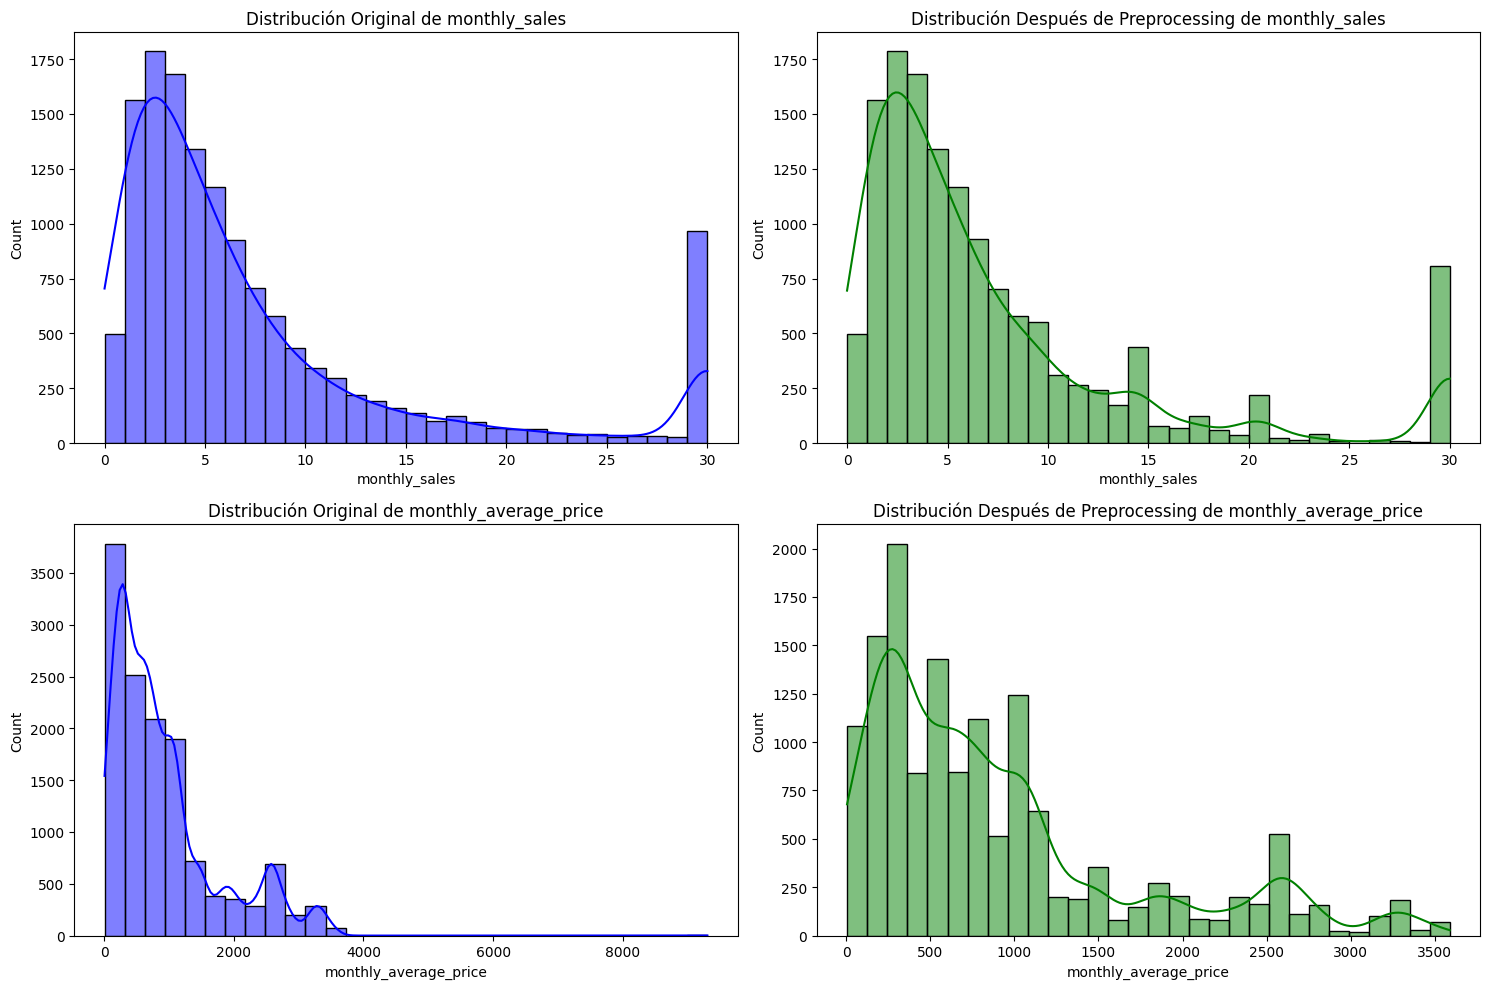

In [10]:
# Ejemplo de uso del visualizador
visualizer = PreprocessingVisualizer(
    variables=["monthly_sales", "monthly_average_price"]
)

original_df = raw_df.copy()

preprocessor_vis = HierarchicalImputerPreprocessor()
preprocessor_vis.fit(original_df)
preprocessed_df = preprocessor_vis.transform(original_df)

visualizer.plot_distributions(original_df, preprocessed_df)

In [11]:
# 1) Split por fecha ANTES del preprocesado
dates = np.sort(raw_df["date"].unique())
train_dates, val_date, test_date = dates[:-2], [dates[-2]], [dates[-1]]

df_train_raw = raw_df[raw_df["date"].isin(train_dates)].copy()
df_val_raw = raw_df[raw_df["date"].isin(val_date)].copy()
df_test_raw = raw_df[raw_df["date"].isin(test_date)].copy()

# 2) Fit SOLO en train
pre = HierarchicalImputerPreprocessor()
df_train = pre.fit_transform(df_train_raw)
df_val = pre.transform(df_val_raw)
df_test = pre.transform(df_test_raw)

🚀 Entrenando HierarchicalImputerPreprocessor...
 -> Parámetros de imputación y capping aprendidos.
🚀 Aplicando transformación de HierarchicalImputerPreprocessor...
 -> Nivel 1: Imputando precios con bfill().ffill() por unique_id...
 -> Aplicando capping a 'monthly_average_price'...
 -> Aplicando capping a 'monthly_sales'...
🚀 Aplicando transformación de HierarchicalImputerPreprocessor...
 -> Nivel 1: Imputando precios con bfill().ffill() por unique_id...
 -> Aplicando capping a 'monthly_average_price'...
 -> Aplicando capping a 'monthly_sales'...
🚀 Aplicando transformación de HierarchicalImputerPreprocessor...
 -> Nivel 1: Imputando precios con bfill().ffill() por unique_id...
 -> Nivel 2: Imputando nulos restantes con medianas por categoría...
 -> Aplicando capping a 'monthly_average_price'...
 -> Aplicando capping a 'monthly_sales'...


In [12]:
# Columna objetivo
TARGET_COL = "monthly_sales"

# Columnas categóricas originales que vienen en los datos
# NOTA: No incluimos 'unique_id' si es solo un identificador y no una característica.
CATEGORICAL_COLS_ORIGINAL = ["city_id", "shop_id", "item_category_id", "item_id"]

# Columnas numéricas originales
NUMERICAL_COLS_ORIGINAL = ["monthly_average_price"]

In [13]:
# ===================================================================
#     Corrección de Tipos
# ===================================================================

# 2. Corregir los tipos de datos de las columnas categóricas
#    Este es el paso clave. Lo hacemos ANTES de cualquier división o entrenamiento.
print(
    "\n--- Paso 2: Asegurando el tipo de dato correcto para las columnas categóricas ---"
)

# Usamos la lista que definimos centralizadamente
for col in CATEGORICAL_COLS_ORIGINAL:
    if col in df_train.columns:
        df_train[col] = df_train[col].astype(int)
    else:
        print(
            f"⚠️ Advertencia: La columna categórica '{col}' no se encontró en el DataFrame."
        )

print(f"✅ Tipos de datos corregidos para: {CATEGORICAL_COLS_ORIGINAL}")


--- Paso 2: Asegurando el tipo de dato correcto para las columnas categóricas ---
✅ Tipos de datos corregidos para: ['city_id', 'shop_id', 'item_category_id', 'item_id']


### 5.2. Feature Engineering & EDA

In [ ]:

# --- PASO 1: Concatenar para crear features que dependen del tiempo ---
full_df_concatenated = pd.concat([df_train, df_val, df_test], ignore_index=True)
print(f"🔧 Dataframes concatenados. Total de filas: {len(full_df_concatenated)}")

# --- PASO 2: Crear TODAS las features con la nueva clase consolidada ---

feature_creator = CoreFeatureEngineer(peak_threshold=25)
full_df_featured = feature_creator.fit_transform(full_df_concatenated)

# --- PASO 3: Volver a separar los dataframes ---
print("\n✅ Separando dataframes con todas las features (aún con NaNs)...")
train_dates = df_train["date"].unique()
val_date = df_val["date"].unique()
test_date = df_test["date"].unique()
features_train = full_df_featured[full_df_featured["date"].isin(train_dates)].copy()
features_val = full_df_featured[full_df_featured["date"].isin(val_date)].copy()
features_test = full_df_featured[full_df_featured["date"].isin(test_date)].copy()

# --- PASO 4: Imputar cada conjunto por separado ---
print("\n🚀 Aplicando imputación inteligente a cada conjunto por separado...")
imputer = SmartImputer(fill_value=0)

features_train = imputer.fit_transform(features_train)
features_val = imputer.transform(features_val)
features_test = imputer.transform(features_test)

🔧 Dataframes concatenados. Total de filas: 14484
✅ ComprehensiveFeatureEngineer inicializado. Umbral de pico: 25

🚀 Ejecutando Comprehensive Feature Engineering...
   -> Creando ratios avanzados de forma segura...
✅ Ingeniería de características finalizada.

✅ Separando dataframes con todas las features (aún con NaNs)...

🚀 Aplicando imputación inteligente a cada conjunto por separado...
Ejecutando SmartImputer...
 -> Imputando features de lag...
 -> Imputando features de rolling window con 0...
 -> Imputando ratios y tendencias...
 -> Imputando features de volatilidad...
 -> Imputando NaNs restantes con 0...
Imputación inteligente finalizada.
Ejecutando SmartImputer...
 -> Imputando features de lag...
 -> Imputando features de rolling window con 0...
 -> Imputando ratios y tendencias...
 -> Imputando features de volatilidad...
 -> Imputando NaNs restantes con 0...
Imputación inteligente finalizada.
Ejecutando SmartImputer...
 -> Imputando features de lag...
 -> Imputando features de r

### **Grafico de estacionalidad**

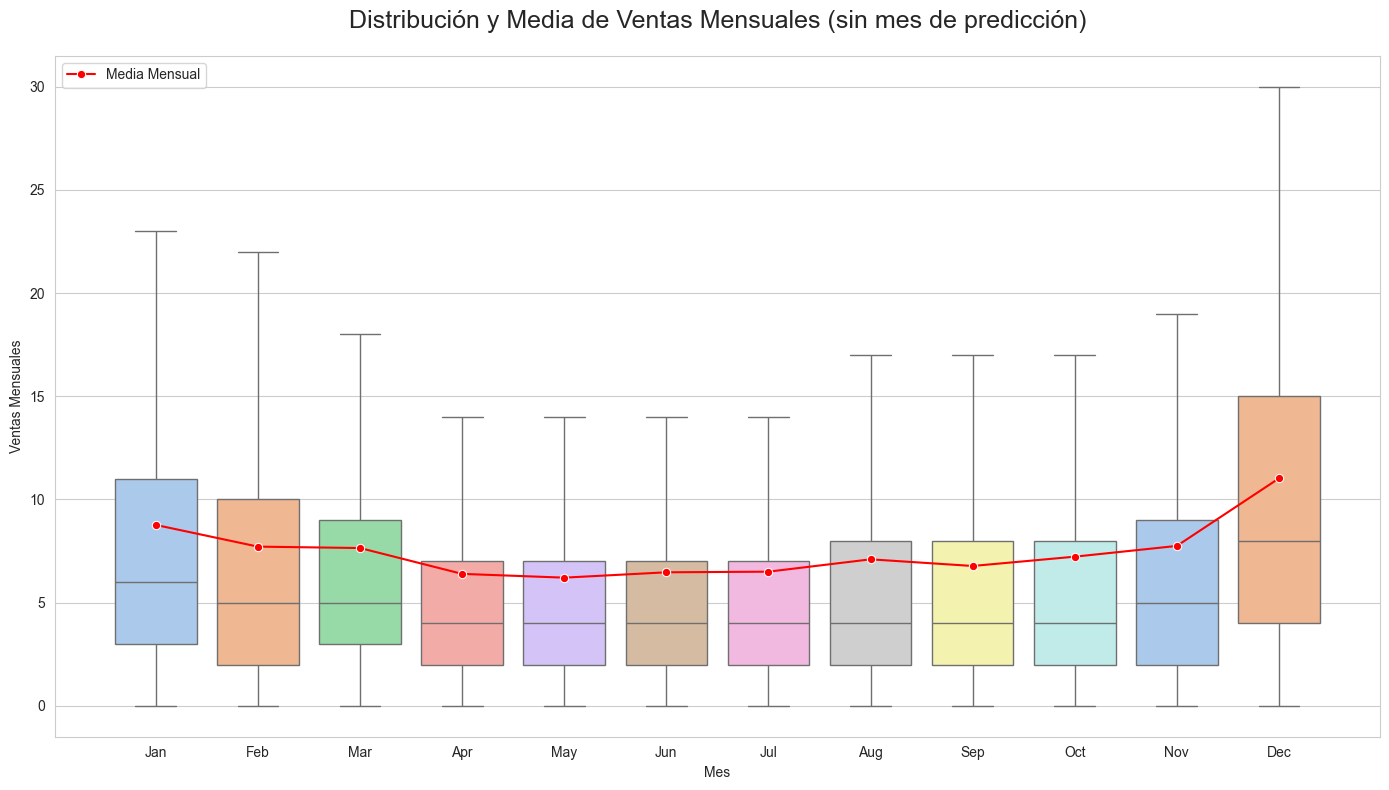

In [15]:
import calendar

order = list(calendar.month_abbr)[1:]  # ['Jan', ..., 'Dec']

# Excluir el último mes del dataset (mes objetivo de predicción)
last_month = raw_df["date"].max()
raw_df_plot = raw_df[raw_df["date"] < last_month].copy()

# Asegurarse de que 'month' está disponible
raw_df_plot["date"] = pd.to_datetime(raw_df_plot["date"])
raw_df_plot["month"] = raw_df_plot["date"].dt.month

# Mes como categoría ordenada
raw_df_plot["month_abbr"] = pd.Categorical(
    raw_df_plot["date"].dt.month.map(lambda m: calendar.month_abbr[m]),
    categories=order,
    ordered=True,
)

# Media mensual ya en la misma categoría/orden
monthly_means = (
    raw_df_plot.groupby("month_abbr", observed=False)["monthly_sales"]
    .mean()
    .reindex(order)
    .reset_index()
)

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

ax = sns.boxplot(
    x="month_abbr",
    y="monthly_sales",
    data=raw_df_plot,
    order=order,
    showfliers=False,
    palette="pastel",
)

sns.lineplot(
    data=monthly_means,
    x="month_abbr",
    y="monthly_sales",
    marker="o",
    color="red",
    label="Media Mensual",
    sort=False,
)

ax.set_xlabel("Mes")
ax.set_ylabel("Ventas Mensuales")
plt.title(
    "Distribución y Media de Ventas Mensuales (sin mes de predicción)",
    fontsize=18,
    pad=20,
)
plt.legend()
plt.tight_layout()
plt.show()

El mes test a predecir (Octubre de 2015), históricamente presenta una distribución similar a setiembre verificamos que setiembre es un buen mes de validación. 

El gráfico confirma la fuerte estacionalidad con picos de ventas en los meses de fin de año (diciembre/enero), lo que valida la creación de features cíclicas (seno/coseno) y las interacciones con el mes.

### **Relación precio-ventas**

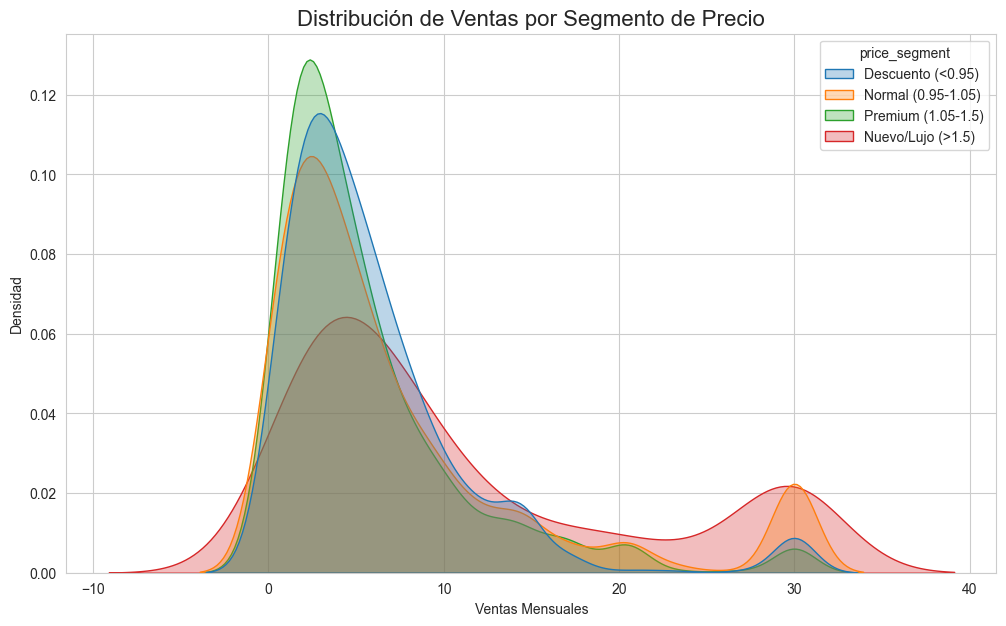

In [16]:
# Crear los segmentos de precio
bins = [0, 0.95, 1.05, 1.5, np.inf]
labels = [
    "Descuento (<0.95)",
    "Normal (0.95-1.05)",
    "Premium (1.05-1.5)",
    "Nuevo/Lujo (>1.5)",
]
df_segmented = features_train.copy()
df_segmented["price_segment"] = pd.cut(
    df_segmented["price_vs_historical_avg_ratio"], bins=bins, labels=labels
)

# Graficar
plt.figure(figsize=(12, 7))
sns.kdeplot(
    data=df_segmented.dropna(subset=["price_segment"]),
    x="monthly_sales",
    hue="price_segment",  # Una curva por cada segmento
    fill=True,
    common_norm=False,  # Normaliza cada curva por separado
    alpha=0.3,
)
plt.title("Distribución de Ventas por Segmento de Precio", fontsize=16)
plt.xlabel("Ventas Mensuales")
plt.ylabel("Densidad")
plt.show()

Observamos que la mayor frecuencia de ventas (densidad en el grafico) se produce cuando el producto es relativamente más caro, esto va ligado a la estacionalidad de las ventas.

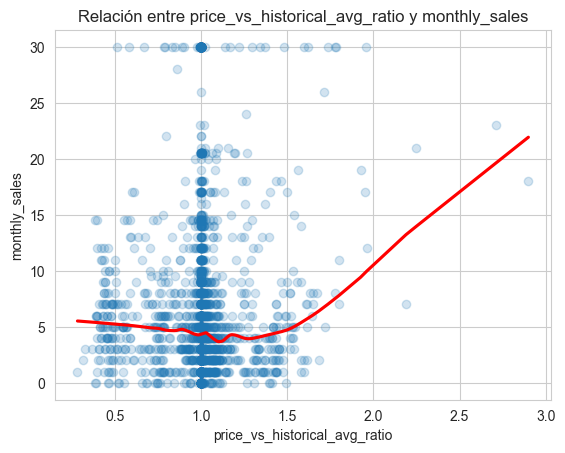

In [17]:
feature_to_plot = "price_vs_historical_avg_ratio"
target = "monthly_sales"

sample_df = features_train.sample(
    n=2000, random_state=42
)  # Usar una muestra para agilidad
sns.regplot(
    data=sample_df,
    x=feature_to_plot,
    y=target,
    scatter_kws={"alpha": 0.2},
    line_kws={"color": "red"},
    lowess=True,
)
plt.title(f"Relación entre {feature_to_plot} y {target}")
plt.show()

- Relación no lineal entre el precio y las ventas.
- El mínimo de ventas esta cerca del precio promedio.
- Ligero repunte en ventas cuando el precio es menor al promedio.

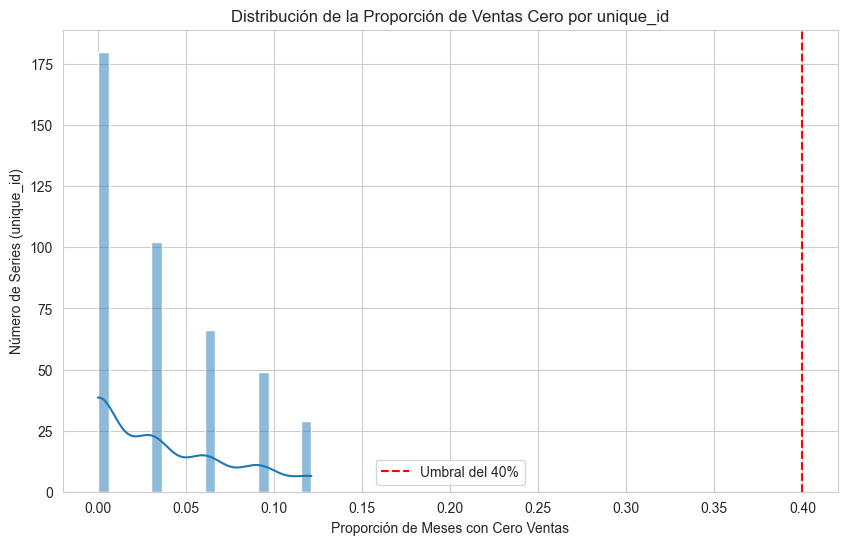

Porcentaje de series con más de un 40% de ceros: 0.00%


In [18]:
# Calcula la proporción de ventas cero para cada serie temporal
df_full_history = pd.concat([df_train, df_val], ignore_index=True)

zero_sales_ratio = df_full_history.groupby("unique_id")["monthly_sales"].apply(
    lambda s: (s == 0).sum() / len(s)
)

# Visualiza la distribución de esta proporción
plt.figure(figsize=(10, 6))
sns.histplot(zero_sales_ratio, bins=20, kde=True)
plt.title("Distribución de la Proporción de Ventas Cero por unique_id")
plt.xlabel("Proporción de Meses con Cero Ventas")
plt.ylabel("Número de Series (unique_id)")
plt.axvline(0.4, color="red", linestyle="--", label="Umbral del 40%")
plt.legend()
plt.show()

print(
    f"Porcentaje de series con más de un 40% de ceros: {(zero_sales_ratio > 0.4).mean() * 100:.2f}%"
)

Los meses con cero ventas no son predominantes, esto es importante para escoger correctamente nuestro función objetivo del modelo.

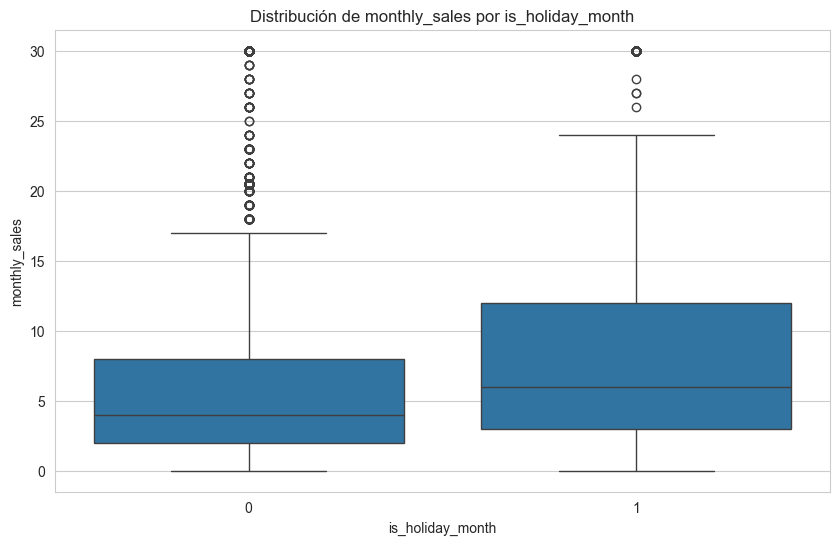

In [19]:
feature_to_plot = "is_holiday_month"
target = "monthly_sales"

plt.figure(figsize=(10, 6))
sns.boxplot(data=features_train, x=feature_to_plot, y=target)
plt.title(f"Distribución de {target} por {feature_to_plot}")
plt.show()

Hay una clara estacionalidad de ventas en los meses de enero y diciembre las ventas son claramente superiores, tanto la mediana como el tercer cuartil.


### **5.3 Data Preparation**



**Estrategia de Validación:** Para simular un escenario de producción real donde predecimos el futuro, se utiliza una estrategia de validación temporal simple y robusta:
-   **Train Set:** Todos los meses disponibles excepto los dos últimos.
-   **Validation Set:** El penúltimo mes del historial.
-   **Test Set:** El último mes del historial (nuestro objetivo final de predicción).

**¿Por qué se ha decidido este tipo de validación del modelo?**
- Por la naturaleza de nuestros datos de series temporales, es crucial que la validación simule un entorno de producción real, donde predecimos el futuro utilizando únicamente información del pasado. Por ello, se descartaron técnicas como la validación cruzada estándar (K-Fold), que mezclaría datos futuros en los pliegues de entrenamiento, provocando una fuga de datos y una evaluación de rendimiento demasiado optimista.

La estrategia elegida, **validar con el mes N-1 y testear con el mes N**, es la más robusta para este problema porque:

1. **Mantiene la Causalidad Temporal**: Asegura que el modelo nunca vea datos del futuro durante su entrenamiento o validación.

2. **Simula el Despliegue:** Refleja exactamente cómo se usaría el modelo en producción: entrenar con toda la historia disponible para predecir el siguiente mes.

3. **Relevancia de los Datos Recientes**: Al validar con el mes más cercano al de test, evaluamos el rendimiento del modelo sobre las condiciones más recientes del mercado, lo cual es fundamental en un entorno de retail dinámico.

Aunque se consideraron métodos como Prophet o ARIMAs, la gran cantidad de series temporales (miles de combinaciones tienda-producto) y la riqueza de las características externas (precio, categoría, etc.) hacen que un enfoque basado en Gradient Boosting sea más adecuado y escalable.


In [20]:
# === Orden y saneo previos (crítico para lags/rolling) ===
for name, df_name in [
    ("train", "features_train"),
    ("val", "features_val"),
    ("test", "features_test"),
]:
    df = globals()[df_name]

    # Tipos correctos
    df["date"] = pd.to_datetime(df["date"])
    df["unique_id"] = df["unique_id"].astype(str)

    # Sin duplicados clave
    dups = df.duplicated(["unique_id", "date"]).sum()
    assert dups == 0, f"Duplicados en ({df_name}): {dups}"

    # Orden causal
    df = df.sort_values(["unique_id", "date"]).reset_index(drop=True)

    # Monotonía por serie
    mono = (
        df.groupby("unique_id")["date"].apply(lambda s: s.is_monotonic_increasing).all()
    )
    assert mono, f"{df_name} no es monótono por unique_id"

    globals()[df_name] = df  # guardar de vuelta

print("✅ features_* ordenados y validados (unique_id, date).")

✅ features_* ordenados y validados (unique_id, date).


In [ ]:

TARGET = "monthly_sales"
COLS_TO_DROP = [TARGET, "date", "unique_id"]

# 1) X/y base (raw)
X_train = features_train.drop(columns=COLS_TO_DROP)
y_train = features_train[TARGET]
X_val = features_val.drop(columns=COLS_TO_DROP)
y_val = features_val[TARGET]
X_test = features_test.drop(columns=COLS_TO_DROP)

# Alinear columnas raw por seguridad
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

# Targets en log 
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print("✅ Conjuntos X/y base creados.")
print(f"   -> Dimensiones de X_train: {X_train.shape}")


# ----------------------------------------------------------------------
# 3) Definición de categóricas (solo para modelos que las usan en RAW)
# ----------------------------------------------------------------------
all_possible_categoricals = [
    "shop_id",
    "item_id",
    "item_category_id",
    "month",
    "year",
    "shop_category_interaction",
    "city_id",
]
categorical_cols_original = [
    c for c in all_possible_categoricals if c in X_train.columns
]
print(f"\nCategóricas para CatBoost (raw): {categorical_cols_original}")

✅ Conjuntos X/y base creados.
   -> Dimensiones de X_train: (13632, 44)

Categóricas para CatBoost (raw): ['shop_id', 'item_id', 'item_category_id', 'month', 'year', 'shop_category_interaction', 'city_id']


In [ ]:
# ----------------------------------------------------------------------
# 2) Target Encoding TIME-AWARE (sin fuga, por bloques temporales t-1)
#    - Usa 'date_block_num' creado por CoreFeatureEngineer._add_time_features
#    - y_train en escala ORIGINAL (no usar y_train_log aquí)
# ----------------------------------------------------------------------

# 2.1) Columnas categóricas a codificar (las mismas que en tu bloque anterior)
cols_for_encoding = [
    "shop_category_interaction",
    "item_category_id",
    "shop_id",
    "item_id",
    "city_id",
]

# 2.2) Sanity checks
assert (
    "date_block_num" in X_train.columns
), "Falta 'date_block_num' en X_train. Revisa _add_time_features."
for c in cols_for_encoding:
    assert c in X_train.columns, f"Falta columna categórica '{c}' en X_train."

# 2.3) Instancia del codificador time-aware.
# Nota: usamos alpha=200 para suavizado.
te_time = TargetEncoderTimeAware(
    cols=cols_for_encoding,
    date_col="date_block_num",
    alpha=200.0,  # suavizado para categorías raras 
    noise=0.01,  # regularización ligera SOLO en train
    min_samples=1,
    drop_original=True,  # quita las columnas categóricas crudas y deja *_enc
    handle_unknown="global_mean",
)

# 2.4) Aplicación del encoding
# IMPORTANTÍSIMO: pasar el DataFrame COMPLETO (no sólo las cols categóricas),
#                 porque el transformador mantiene el resto de features tal cual.
X_train_encoded_reg = te_time.fit_transform(X_train.copy(), y_train)
X_val_encoded_reg = te_time.transform(X_val.copy())
X_test_encoded_reg = te_time.transform(X_test.copy())

# 2.5) Alinear columnas por seguridad (mismo orden para val/test que train)
X_val_encoded_reg = X_val_encoded_reg.reindex(
    columns=X_train_encoded_reg.columns, fill_value=np.nan
)
X_test_encoded_reg = X_test_encoded_reg.reindex(
    columns=X_train_encoded_reg.columns, fill_value=np.nan
)

# 2.6) Sanity checks finales
print("\n✅ Target Encoding TIME-AWARE aplicado sin fuga.")
print("   -> Dimensiones de X_train_encoded_reg:", X_train_encoded_reg.shape)
assert list(X_val_encoded_reg.columns) == list(
    X_train_encoded_reg.columns
), "Columnas de VAL no alineadas con TRAIN"
assert list(X_test_encoded_reg.columns) == list(
    X_train_encoded_reg.columns
), "Columnas de TEST no alineadas con TRAIN"


✅ Target Encoding TIME-AWARE aplicado sin fuga.
   -> Dimensiones de X_train_encoded_reg: (13632, 44)


## 5.4 Model training

No todos los modelos aprenden de la misma manera. Una estrategia clave para construir un ensamble robusto es entrenar modelos con diferentes funciones objetivo (objective). Cada función le enseña al modelo a optimizar el error desde una perspectiva matemática distinta, lo que resulta en predicciones diversas que se complementan entre sí.

Dada la naturaleza de nuestros datos de ventas (números enteros, con presencia de ceros y una distribución sesgada), se eligieron las siguientes funciones objetivo:

- **regression_l1** (MAE - Error Absoluto Medio): Este objetivo es menos sensible a los valores atípicos que el RMSE estándar. Aunque ya hemos realizado un capping de outliers, las ventas en meses de alta demanda (como diciembre) pueden seguir siendo significativamente altas. Un modelo L1 tiende a producir predicciones más estables y cercanas a la mediana, lo cual es útil para el ensamble.

- **poisson**: La regresión de Poisson está diseñada específicamente para modelar datos de conteo (como el número de unidades vendidas). Asume que la varianza es igual a la media y es una elección natural para este tipo de datos, especialmente porque maneja bien los valores cero, que son comunes en productos con ventas intermitentes.

- **tweedie**: Es una función objetivo muy potente y flexible, ideal para nuestro caso. La distribución Tweedie es una generalización que puede modelar distribuciones con una mezcla de ceros exactos y valores positivos continuos y sesgados (como las ventas). El parámetro tweedie_variance_power=1.5 la sitúa entre una distribución de Poisson (valor=1) y una Gamma (valor=2), capturando perfectamente la naturaleza de "cero-inflado" de los datos de ventas.

- **reg:squarederror** con Transformación Logarítmica: Para XGBoost y CatBoost, en lugar de cambiar el objetivo, transformamos la variable objetivo aplicándole el logaritmo (np.log1p). Esto ayuda a normalizar la distribución de las ventas, que está muy sesgada a la derecha. El modelo, al minimizar el error cuadrático sobre el logaritmo, penaliza más los errores relativos (porcentuales) que los absolutos. Esto evita que unas pocas predicciones con ventas muy altas dominen la función de pérdida y resulta en un modelo más equilibrado.

In [23]:
# ==============================================================================
# CELDA 33: CONFIGURACIÓN DE MODELOS (VERSIÓN AFINADA)
# ==============================================================================
def get_model_configs():
    """
    Retorna configuraciones afinadas para cada modelo.
    - Estrategia: Dar más capacidad a los modelos con subajuste (Tweedie, L1, CatBoost).
    -           Hacer ajustes finos en los modelos bien calibrados (Poisson, XGBoost).
    """

    return {
        "LightGBM_L1": {
            "model": lgb.LGBMRegressor,
            "params": {
                "objective": "regression_l1",
                "metric": "rmse",
                "n_estimators": 6000,
                "learning_rate": 0.03,
                "num_leaves": 40,
                "max_depth": 9,
                "min_child_samples": 30,
                "subsample": 0.85,
                "colsample_bytree": 0.80,
                "reg_alpha": 0.1,
                "reg_lambda": 0.5,
                "random_state": 42,
                "n_jobs": -1,
                "verbose": -1,
            },
            "target_scale": "log",
        },
        "LightGBM_Tweedie": {
            "model": lgb.LGBMRegressor,
            "params": {
                "objective": "tweedie",
                "metric": "rmse",
                "tweedie_variance_power": 1.56,  # mantenemos el p ganador
                "n_estimators": 20000,
                "learning_rate": 0.015,
                "num_leaves": 127,  # ↓ desde 191
                "max_depth": -1,
                "min_child_samples": 100,  # ↑ desde 40
                "feature_fraction": 0.75,  # ↓ desde 0.85
                "bagging_fraction": 0.75,  # ↓ desde 0.85
                "bagging_freq": 5,
                "reg_alpha": 0.1,
                "reg_lambda": 2.0,  # ↑ regularización
                "max_bin": 255,
                "min_sum_hessian_in_leaf": 0.01,
                "random_state": 42,
                "n_jobs": -1,
                "verbose": -1,
            },
            "target_scale": "original",
        },
        "LightGBM_Poisson": {
            "model": lgb.LGBMRegressor,
            "params": {
                "objective": "poisson",
                "metric": "rmse",
                "n_estimators": 6000,
                "learning_rate": 0.03,
                "num_leaves": 25,
                "max_depth": 7,
                "min_child_samples": 100,
                "feature_fraction": 0.70,
                "bagging_fraction": 0.75,
                "bagging_freq": 1,
                "reg_alpha": 0.5,
                "reg_lambda": 2.0,
                "random_state": 42,
                "n_jobs": -1,
                "verbose": -1,
            },
            "target_scale": "original",
        },
        "XGBoost": {
            "model": xgb.XGBRegressor,
            "params": {
                "objective": "reg:squarederror",
                "eval_metric": "rmse",
                "n_estimators": 4000,
                "learning_rate": 0.025,
                "max_depth": 8,
                "subsample": 0.8,
                "colsample_bytree": 0.75,
                "min_child_weight": 5,
                "gamma": 0.5,
                "reg_alpha": 0.1,
                "reg_lambda": 2.5,
                "n_jobs": -1,
                "seed": 175,
            },
            "target_scale": "log",
        },
        "CatBoost": {
            "model": CatBoostRegressor,
            "params": {
                "iterations": 8000,
                "learning_rate": 0.04,
                "depth": 10,
                "l2_leaf_reg": 1.5,
                "subsample": 0.90,
                "bootstrap_type": "Bernoulli",
                "random_strength": 0.3,
                "rsm": 0.85,
                "loss_function": "RMSE",
                "eval_metric": "RMSE",
                "early_stopping_rounds": 300,
                "verbose": False,
                "random_seed": 42,
                "task_type": "CPU",
            },
            "target_scale": "log",
        },
        "RandomForest": {
            "model": RandomForestRegressor,
            "params": {
                "n_estimators": 500,
                "max_depth": 12,
                "min_samples_split": 15,
                "min_samples_leaf": 8,
                "max_features": "sqrt",
                "n_jobs": -1,
                "random_state": 42,
            },
            "target_scale": "log",
        },
    }

In [24]:
# ================================
# ENTRENAMIENTO MODELOS BASE (FULL)
# ================================


def _select_data_for_model(name, X_raw_train, X_raw_val, X_enc_train, X_enc_val):
    """Devuelve (Xtr, Xval, uses_encoded) según el modelo."""
    if name in ["CatBoost", "RandomForest"]:
        return X_raw_train, X_raw_val, False
    else:
        return X_enc_train, X_enc_val, True


def _inverse_target_if_needed(arr, target_scale):
    """Devuelve y en escala ORIGINAL según la config del modelo."""
    return np.expm1(arr) if target_scale == "log" else arr


def _best_pred_lgb(model, X):
    """Predicción LightGBM usando best_iteration si existe."""
    num_iter = (
        getattr(model, "best_iteration_", None)
        or getattr(model, "best_iteration", None)
        or getattr(model, "n_estimators", None)
    )
    return model.predict(X, num_iteration=num_iter)


def _best_pred_xgb(model, X):
    """Predicción XGBoost usando mejor límite de árboles si existe."""

    best_iter = getattr(model, "best_iteration", None)
    if best_iter is not None:

        try:
            return model.predict(X, iteration_range=(0, best_iter + 1))
        except TypeError:
            pass

    ntree_limit = getattr(model, "best_ntree_limit", None) or getattr(
        getattr(model, "get_booster", lambda: None)(), "best_ntree_limit", None
    )
    if ntree_limit:
        return model.predict(X, ntree_limit=ntree_limit)
    return model.predict(X)


def _clip_positive(arr, low=0.0, high=30.0):
    return np.clip(arr, low, high)


# --- preparación de columnas para encoded ---
# Alinea columnas para evitar KeyError si hubo drift entre train/val
X_val_encoded_reg = X_val_encoded_reg.reindex(
    columns=X_train_encoded_reg.columns, fill_value=0.0
)

early_stopping_patience = 300  # un poco más generoso para CatBoost/LGBM con 6k-8k trees
model_configs = get_model_configs()

results = {}
trained_models = {}
trained_feature_cols = {}
trained_meta = {}

print("🚀 INICIANDO ENTRENAMIENTO DE MODELOS BASE (FULL encoded para LGBM/XGB)")
print("=" * 70)

for i, (name, config) in enumerate(model_configs.items(), 1):
    print(f"\n[{i}/{len(model_configs)}] 🏋️ ENTRENANDO {name}")

    model_class = config["model"]
    params = config["params"].copy()
    target_scale = config["target_scale"]

    # --- crear modelo ---
    model = model_class(**params)
    print(f"✅ Modelo creado: {type(model).__name__}")

    # --- target ---
    if target_scale == "log":
        print("   -> Target: LOGARÍTMICA")
        y_train_fit, y_val_fit = y_train_log, y_val_log
    else:
        print("   -> Target: ORIGINAL")
        y_train_fit, y_val_fit = y_train, y_val

    # --- seleccionar dataset (RAW vs ENCODED) ---
    X_tr, X_vl, used_encoded = _select_data_for_model(
        name, X_train, X_val, X_train_encoded_reg, X_val_encoded_reg
    )
    trained_feature_cols[name] = list(X_tr.columns)

    # --- entrenamiento con early stopping por modelo ---
    print(f"🔄 Entrenando {name}...")
    if "LightGBM" in name:
        model.fit(
            X_tr,
            y_train_fit,
            eval_set=[(X_vl, y_val_fit)],
            callbacks=[
                lgb.early_stopping(early_stopping_patience, verbose=False),
                lgb.log_evaluation(0),
            ],
        )

    elif name == "XGBoost":
        # XGBEarlyStopping
        model.fit(
            X_tr,
            y_train_fit,
            eval_set=[(X_vl, y_val_fit)],
            verbose=False,
            callbacks=[
                XGBEarlyStopping(rounds=early_stopping_patience, save_best=True)
            ],
        )

    elif name == "CatBoost":
        # CatBoost en datos RAW, usa best model automático con eval_set
        model.fit(
            X_tr,
            y_train_fit,
            eval_set=(X_vl, y_val_fit),
            cat_features=categorical_cols_original,
            use_best_model=True,
            verbose=False,
        )

    elif name == "RandomForest":
        model.fit(X_tr, y_train_fit)

    print(f"✅ {name} entrenado exitosamente")

    # --- predicción usando la mejor iteración ---
    print(f"📊 Evaluando {name}...")

    if "LightGBM" in name:
        preds_val = _best_pred_lgb(model, X_vl)
        preds_trn = _best_pred_lgb(model, X_tr)
        best_it = getattr(model, "best_iteration_", None) or getattr(
            model, "best_iteration", None
        )
    elif name == "XGBoost":
        preds_val = _best_pred_xgb(model, X_vl)
        preds_trn = _best_pred_xgb(model, X_tr)
        best_it = getattr(model, "best_iteration", None)
    elif name == "CatBoost":
        preds_val = model.predict(X_vl)
        preds_trn = model.predict(X_tr)
        best_it = model.get_params().get(
            "iterations", None
        )  # CatBoost ya guardó el best interno
    else:  # RandomForest
        preds_val = model.predict(X_vl)
        preds_trn = model.predict(X_tr)
        best_it = None

    # --- escala original + clipping coherente ---
    preds_val_orig = _inverse_target_if_needed(preds_val, target_scale)
    preds_trn_orig = _inverse_target_if_needed(preds_trn, target_scale)

    preds_val_orig = _clip_positive(preds_val_orig, 0, 30)
    preds_trn_orig = _clip_positive(preds_trn_orig, 0, 30)

    val_preds_original = val_preds_original if "val_preds_original" in globals() else {}
    val_preds_original[name] = preds_val_orig

    train_preds_original = (
        train_preds_original if "train_preds_original" in globals() else {}
    )
    train_preds_original[name] = preds_trn_orig

    # --- métricas ---
    rmse_val = np.sqrt(mean_squared_error(y_val, preds_val_orig))
    rmse_trn = np.sqrt(mean_squared_error(y_train, preds_trn_orig))

    print(
        f"✅ {name} → RMSE Train: {rmse_trn:.4f} | RMSE Val: {rmse_val:.4f} | Gap: {rmse_val/rmse_trn:.3f}x"
    )

    # --- guardar resultados ---
    results[name] = {"model": model, "rmse_val": rmse_val, "rmse_train": rmse_trn}
    trained_models[name] = model
    trained_meta[name] = {
        "used_encoded": used_encoded,
        "best_iteration": best_it,
        "n_features": X_tr.shape[1],
        "feature_cols": trained_feature_cols[name],
        "target_scale": target_scale,
    }

    print("-" * 50)

print("\n" + "=" * 70)
print("🏁 ENTRENAMIENTO COMPLETADO")

# --- mejor modelo por RMSE validación ---
best_model_name, best_model_info = min(results.items(), key=lambda x: x[1]["rmse_val"])
print(f"\n🏆 MEJOR MODELO BASE: {best_model_name}")
print(
    f"📈 RMSE Val: {best_model_info['rmse_val']:.4f} | RMSE Train: {best_model_info['rmse_train']:.4f}"
)

print(f"\n📊 RESUMEN COMPLETO:")
print("-" * 60)
for name, info in sorted(results.items(), key=lambda x: x[1]["rmse_val"]):
    print(
        f"{name:15} | RMSE Train: {info['rmse_train']:.4f} | RMSE Val: {info['rmse_val']:.4f} | Encoded: {trained_meta[name]['used_encoded']} | Best it: {trained_meta[name]['best_iteration']}"
    )

🚀 INICIANDO ENTRENAMIENTO DE MODELOS BASE (FULL encoded para LGBM/XGB)

[1/6] 🏋️ ENTRENANDO LightGBM_L1
✅ Modelo creado: LGBMRegressor
   -> Target: LOGARÍTMICA
🔄 Entrenando LightGBM_L1...
✅ LightGBM_L1 entrenado exitosamente
📊 Evaluando LightGBM_L1...
✅ LightGBM_L1 → RMSE Train: 2.8796 | RMSE Val: 2.7645 | Gap: 0.960x
--------------------------------------------------

[2/6] 🏋️ ENTRENANDO LightGBM_Tweedie
✅ Modelo creado: LGBMRegressor
   -> Target: ORIGINAL
🔄 Entrenando LightGBM_Tweedie...
✅ LightGBM_Tweedie entrenado exitosamente
📊 Evaluando LightGBM_Tweedie...
✅ LightGBM_Tweedie → RMSE Train: 2.6831 | RMSE Val: 2.7445 | Gap: 1.023x
--------------------------------------------------

[3/6] 🏋️ ENTRENANDO LightGBM_Poisson
✅ Modelo creado: LGBMRegressor
   -> Target: ORIGINAL
🔄 Entrenando LightGBM_Poisson...
✅ LightGBM_Poisson entrenado exitosamente
📊 Evaluando LightGBM_Poisson...
✅ LightGBM_Poisson → RMSE Train: 2.6414 | RMSE Val: 2.7604 | Gap: 1.045x
---------------------------------

#### Resultados de los Modelos Base

Se entrenaron 6 modelos potentes sobre el conjunto completo de características. Los resultados muestran un buen control del sobreajuste en todos los casos. **Catboost y LGBM Tweedie emergen como los modelos individuales más fuertes**, con XGBoost muy cerca, demostrando la eficacia del pipeline de preprocesamiento e ingeniería de características.

## 5.5. Análisis de Importancia de Características

Para entender qué impulsa las predicciones, analizamos la importancia de las características de nuestro mejor modelo individual, `CatBoost`. Se utiliza la **importancia por permutación** , que es una técnica robusta que mide cuánto empeora el rendimiento del modelo si una característica es "barajada" al azar, dándonos una medida real de su valor predictivo. Tambien se utiliza la **importancia nativa del modelo**.

In [25]:
# --- 1. Cálculo de la Importancia (tu código, sin cambios) ---
best_model_name = "CatBoost"
best_model = trained_models[best_model_name]


X_val_for_importance = X_val.copy()


print("🩺 Verificando y corrigiendo dtypes para CatBoost...")
for col in categorical_cols_original:
    if col in X_val_for_importance.columns:
        X_val_for_importance[col] = X_val_for_importance[col].astype(int)
print("   -> Dtypes corregidos.")

print(f"\\n⏳ Calculando Importancia por Permutación para {best_model_name}...")
result = permutation_importance(
    best_model,
    X_val_for_importance,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

perm_importance_df = (
    pd.DataFrame(
        {
            "feature": X_val_for_importance.columns,
            "importance_mean": result.importances_mean,
        }
    )
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

print("✅ Cálculo finalizado.")

# --- 2. Visualización Mejorada ---
N_FEATURES_TO_SHOW = 25  # Puedes ajustar cuántas features mostrar

fig = px.bar(
    perm_importance_df.head(N_FEATURES_TO_SHOW),
    x="importance_mean",
    y="feature",
    orientation="h",
    title=f"Top {N_FEATURES_TO_SHOW} - Permutation Importance ({best_model_name})",
    labels={"importance_mean": "Importancia Media", "feature": "Característica"},
)

fig.update_layout(
    height=800,
    margin=dict(l=400),
    yaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
    xaxis=dict(title_font=dict(size=14)),
    title_font=dict(size=18),
    template="plotly_white",
)

fig.update_yaxes(autorange="reversed")
fig.show()

🩺 Verificando y corrigiendo dtypes para CatBoost...
   -> Dtypes corregidos.
\n⏳ Calculando Importancia por Permutación para CatBoost...
✅ Cálculo finalizado.


In [26]:
df_importance_cat = plot_native_importance(
    best_model, X_val_for_importance, model_name="CatBoost"
)

**Features top en ambos rankings:**
- monthly_sales_rolling_mean_3, monthly_sales_rolling_mean_6: . Esto demuestra que la tendencia de ventas más reciente (promedio de los últimos 3 y 6 meses) es, con diferencia, el predictor más potente.
- monthly_sales_lag_1:  Las ventas del mes inmediatamente anterior son cruciales para predecir las del mes actual.
- item_id y item_category_id: Ambas se mantienen en el Top 6 en los dos rankings. Esto confirma que la identidad del producto y su categoría son fundamentales.

**Features que Pierden Importancia por Permutación**
- shop_id: Su información predictiva ya está contenida de una forma mucho más potente en la feature shop_category_interaction.
- year: a variable year es una forma simple de capturar la tendencia a largo plazo.  Sin embargo, las features de lag y rolling window (como monthly_sales_rolling_mean_6) ya capturan esta progresión temporal de una forma mucho más sofisticada.
- price_to_category_ratio: Cae en el top de permutación debido al solapamiento de información. Es decir, la información que aporta sobre los precios ya está presente en otras features relacionadas (monthly_average_price, item_avg_price, price_vs_historical_avg_ratio).



In [27]:
# --- 1. Cálculo de la Importancia (tu código, sin cambios) ---
best_model_name = "LightGBM_Tweedie"
best_model = trained_models[best_model_name]

X_val_for_importance = X_val_encoded_reg.copy()  # Usamos una copia para seguridad

# Corregir dtypes para LGBM antes de la evaluación
print("🩺 Verificando y corrigiendo dtypes para LGBM...")
for col in categorical_cols_original:
    if col in X_val_for_importance.columns:
        X_val_for_importance[col] = X_val_for_importance[col].astype(int)
print("   -> Dtypes corregidos.")

print(f"\\n⏳ Calculando Importancia por Permutación para {best_model_name}...")
result = permutation_importance(
    best_model,
    X_val_for_importance,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

perm_importance_df = (
    pd.DataFrame(
        {
            "feature": X_val_for_importance.columns,
            "importance_mean": result.importances_mean,
        }
    )
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

print("✅ Cálculo finalizado.")

# --- 2. Visualización Mejorada ---
N_FEATURES_TO_SHOW = 25  # Puedes ajustar cuántas features mostrar

fig = px.bar(
    perm_importance_df.head(N_FEATURES_TO_SHOW),
    x="importance_mean",
    y="feature",
    orientation="h",
    title=f"Top {N_FEATURES_TO_SHOW} - Permutation Importance ({best_model_name})",
    labels={"importance_mean": "Importancia Media", "feature": "Característica"},
)

fig.update_layout(
    height=800,
    margin=dict(l=400),
    yaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
    xaxis=dict(title_font=dict(size=14)),
    title_font=dict(size=18),
    template="plotly_white",
)

fig.update_yaxes(autorange="reversed")
fig.show()

🩺 Verificando y corrigiendo dtypes para LGBM...
   -> Dtypes corregidos.
\n⏳ Calculando Importancia por Permutación para LightGBM_Tweedie...
✅ Cálculo finalizado.


In [28]:
df_importance_xgb = plot_native_importance(
    best_model, X_val_for_importance, model_name="lgbm_tweedie"
)


**Claves del Análisis de Importancia**

**1. Importancia Nativa: “atajos” potentes**
El modelo otorga gran peso a las variables codificadas con *Target Encoding* (item\_id\_enc, item\_category\_id\_enc, etc.) y a las interacciones. Es lógico: condensan el historial de ventas en un único número y facilitan el aprendizaje.

**2. Importancia por Permutación: la realidad predictiva**
Cuando se mide el impacto real en las predicciones, el panorama cambia. Las variables decisivas son las que reflejan la dinámica reciente de ventas:

* **monthly\_sales\_rolling\_mean\_3**: media de los últimos 3 meses, la más crítica.
* **monthly\_sales\_lag\_1**: ventas del mes anterior.
* **monthly\_sales\_rolling\_mean\_6**: tendencia de corto-medio plazo.

Las codificaciones siguen siendo útiles, pero su información está ya capturada por los lags y medias móviles. Al barajar la media de 3 meses, la precisión se desploma; al barajar *item\_id\_enc*, casi no cambia.

**Conclusión**

El motor real del modelo es el comportamiento reciente de ventas. Las *features* que lo describen —lags y *rolling means*— concentran el verdadero poder predictivo.


## 5.6 Análisis de errores

En esta sección se va a realizar un pequño análisis de errores en la predicción del conjunto de validación.

Se considera el mejor modelo de entre los modelos que estan utilizando el target encoder (LGBM Tweedie).

In [29]:
best_model_object = results["LightGBM_Tweedie"]["model"]
best_model_vals_preds = best_model_object.predict(X_val_encoded_reg)
# xgb_vals_preds = np.expm1(xgb_vals_preds)  # Revertir log si es necesario
best_model_vals_preds_clipped = np.clip(best_model_vals_preds, 0, 30)

Usando longitud mínima: 426


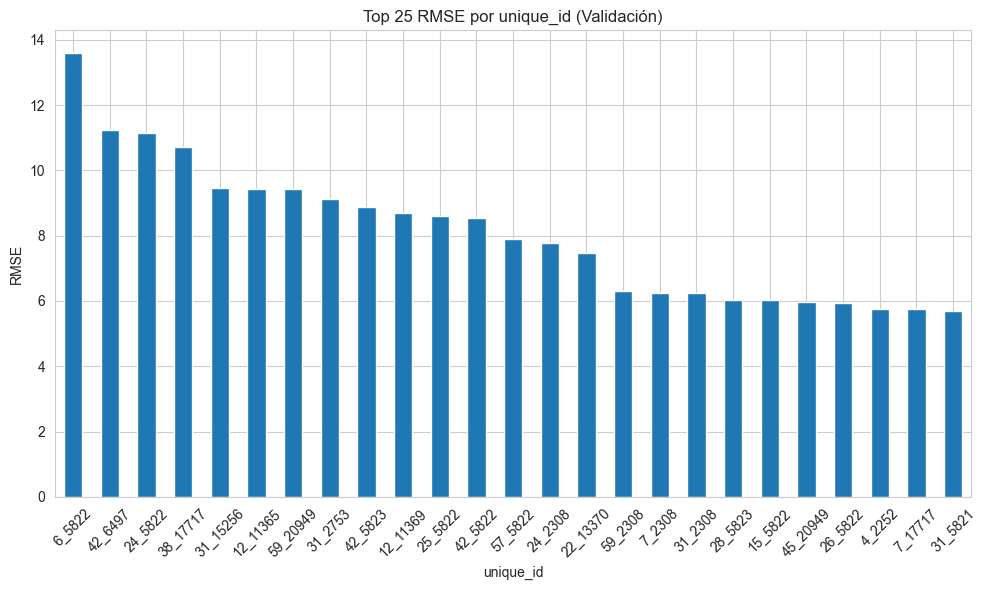

In [30]:
unique_id = features_val["unique_id"].copy()
unique_id = unique_id.astype(str)
y_true = np.array(y_val).flatten()
y_pred = np.array(best_model_vals_preds_clipped).flatten()

min_length = min(len(unique_id), len(y_true), len(y_pred))
print(f"Usando longitud mínima: {min_length}")

unique_id = unique_id[:min_length]
y_true = y_true[:min_length]
y_pred = y_pred[:min_length]

# Calcula el RMSE por unique_id en el conjunto de validación
df_rmse = pd.DataFrame({"unique_id": unique_id, "y_true": y_true, "y_pred": y_pred})

# Agrupa por unique_id y calcula el RMSE
rmse_by_id = (
    df_rmse.groupby("unique_id")
    .apply(
        lambda df: ((df["y_true"] - df["y_pred"]) ** 2).mean() ** 0.5,
        include_groups=False,
    )
    .sort_values(ascending=False)
)

# Selecciona los 25 unique_id con mayor RMSE
top_25_rmse = rmse_by_id.head(25)

# Plot
plt.figure(figsize=(10, 6))
top_25_rmse.plot(kind="bar")
plt.ylabel("RMSE")
plt.xlabel("unique_id")
plt.title("Top 25 RMSE por unique_id (Validación)")
plt.xticks(rotation=45)  # Rotar etiquetas
plt.tight_layout()
plt.show()

In [31]:
df_rmse["RMSE"] = df_rmse["unique_id"].map(rmse_by_id)
df_rmse_sorted = df_rmse[df_rmse["RMSE"].notna()].sort_values(
    by="RMSE", ascending=False
)
top_25 = df_rmse_sorted.head(25)
top_25

,unique_id,y_true,y_pred,RMSE
411,6_5822,20.5,6.889823,13.610177
279,42_6497,18.0,6.764999,11.235001
87,24_5822,18.0,6.865724,11.134276
253,38_17717,14.0,24.717523,10.717523
189,31_15256,12.0,2.527889,9.472111
0,12_11365,21.0,11.558305,9.441695
393,59_20949,18.0,27.425791,9.425791
214,31_2753,14.0,4.880384,9.119616
278,42_5823,18.0,9.123472,8.876528
1,12_11369,30.0,21.309380,8.690620


Se observa que las predicciones con mayor RMSE se encuentran en el rango  13-21 de monthly_sales, eso es debido a que es un rango de ventas con poca representación en el histórico de ventas como se puede observar en la distribución de ventas en la celda 10.
Para solventar el error, mi idea era intentar reducir el RMSE haciendo data augmentation para este rango de ventas, pero no es una buena práctica y resulta en más ruido en el modelo.

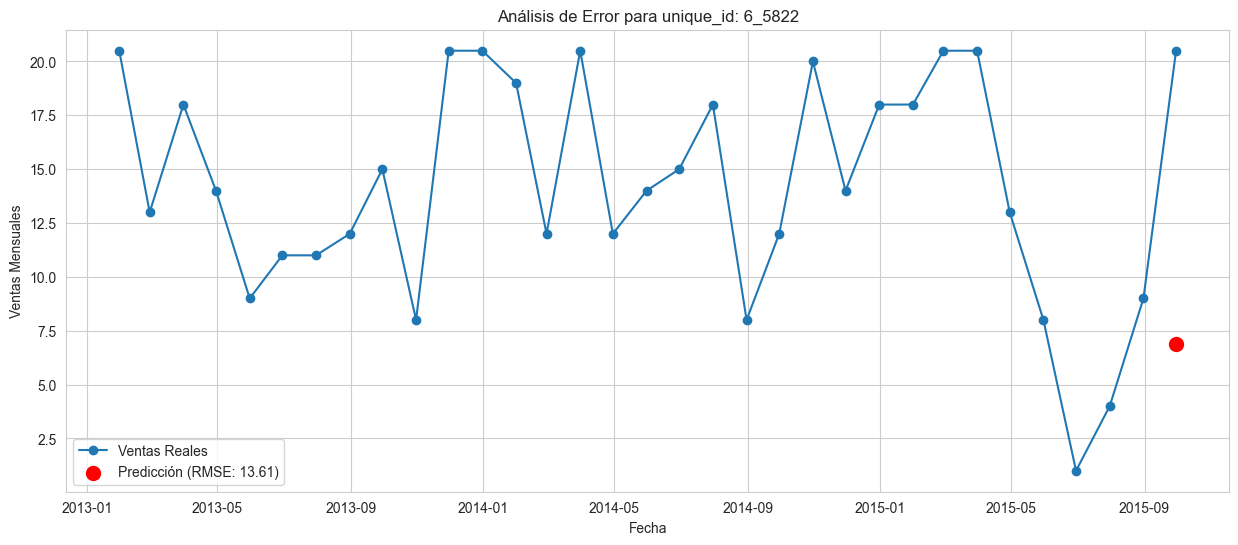

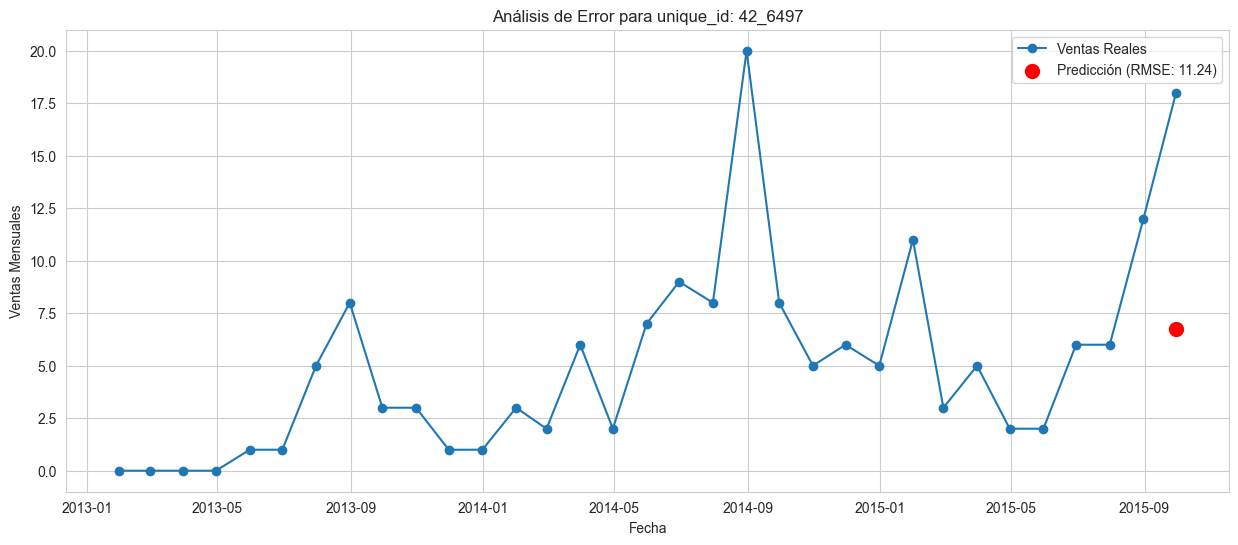

In [32]:
ids_con_mayor_error = top_25_rmse.index[:2]

for uid in ids_con_mayor_error:
    # Filtrar datos históricos y de validación para este unique_id
    hist_data = features_train[features_train["unique_id"] == uid]
    val_data = features_val[features_val["unique_id"] == uid]

    # Combinar para tener el historial completo
    full_series = pd.concat([hist_data, val_data])

    # Obtener la predicción para este id
    pred_val = df_rmse_sorted[df_rmse_sorted["unique_id"] == uid]["y_pred"].iloc[0]

    plt.figure(figsize=(15, 6))
    plt.plot(
        full_series["date"],
        full_series["monthly_sales"],
        label="Ventas Reales",
        marker="o",
    )

    # Añadir la predicción de validación al gráfico
    plt.scatter(
        val_data["date"],
        pred_val,
        color="red",
        s=100,
        zorder=5,
        label=f"Predicción (RMSE: {rmse_by_id.loc[uid]:.2f})",
    )

    plt.title(f"Análisis de Error para unique_id: {uid}")
    plt.xlabel("Fecha")
    plt.ylabel("Ventas Mensuales")
    plt.legend()
    plt.show()

- Como vemos en el gráfico, el unique_id 6_5822 tiene un pico de ventas histórico muy errático, y presenta una alta volatilidad. Posiblemente por ser un producto de nicho o sujeto a promociones esporádicas que el modelo no captura con las features actuales.
  
-  Por otro lado el unique_id 42_6497 tiene unos picos de ventas muy pronunciados, que teniendo en cuenta el comportamiento del Tweedie, donde sus estimaciones tienden a la media justifica aún más el uso de un blending de modelos para la predicción final. 

## 6. Creación del Ensemble Final: Blending y Calibración

Aunque los modelos individuales son fuertes, es posible obtener una mejora adicional combinando sus predicciones. La técnica del **Blending** (un tipo de Stacking) utiliza las predicciones de los modelos base como características para entrenar un meta-modelo final, que aprende a ponderar las fortalezas de cada uno.

Se seleccionaron los 3 mejores y más diversos modelos (`LightGBM_Tweedie`, `XGBoost` y `CatBoost`) para el ensamble. Se utilizó un **Regresor Ridge** como meta-modelo, que encuentra de forma eficiente los pesos óptimos y aplica una calibración lineal para corregir cualquier sesgo sistemático en las predicciones del blend.

In [ ]:

# --- Helpers de alineación (sin cambios, son robustos) ---
def align_to_cat_model(df, expected_cols, categorical_cols):
    df_aligned = df.copy().reindex(columns=expected_cols, fill_value=0)
    for c in categorical_cols:
        if c in df_aligned.columns:
            df_aligned[c] = df_aligned[c].astype(int)
    cat_idx = [i for i, col in enumerate(df_aligned.columns) if col in categorical_cols]
    return df_aligned, cat_idx


def align_by_name(df, expected_cols):
    return df.copy().reindex(columns=expected_cols, fill_value=0)


# ---------------------------
# 1) Predicciones de CatBoost (Datos RAW Completos)
# ---------------------------
cat_model = trained_models["CatBoost"]
expected_cb_cols = getattr(cat_model, "feature_names_", list(X_train.columns))
categorical_cols_cat = [c for c in categorical_cols_original if c in expected_cb_cols]
X_val_cb_aligned, cat_idx_val = align_to_cat_model(
    X_val, expected_cb_cols, categorical_cols_cat
)
val_pool = Pool(data=X_val_cb_aligned, cat_features=cat_idx_val)
preds_val_cat_log = cat_model.predict(val_pool)
preds_val_cat = np.expm1(preds_val_cat_log)
print("   -> Predicciones de CatBoost obtenidas.")

# ---------------------------
# 2) Predicciones de XGBoost (Datos ENCODED Completos)
# ---------------------------
xgb_model = trained_models["XGBoost"]
expected_xgb_cols = getattr(
    xgb_model, "feature_names_in_", list(X_train_encoded_reg.columns)
)
X_val_xgb_aligned = align_by_name(X_val_encoded_reg, expected_xgb_cols)
preds_val_xgb_log = xgb_model.predict(X_val_xgb_aligned)
preds_val_xgb = np.expm1(preds_val_xgb_log)
print("   -> Predicciones de XGBoost obtenidas.")

# ---------------------------
# 3) Predicciones de LightGBM_Tweedie (Datos ENCODED Completos) 
# ---------------------------
tweedie_model = trained_models["LightGBM_Tweedie"]
expected_tweedie_cols = getattr(
    tweedie_model, "feature_name_", list(X_train_encoded_reg.columns)
)
X_val_tweedie_aligned = align_by_name(X_val_encoded_reg, expected_tweedie_cols)
# --- ¡OJO! Tweedie predice en escala original, no necesita np.expm1() ---
preds_val_tweedie = tweedie_model.predict(X_val_tweedie_aligned)
print("   -> Predicciones de LightGBM_Tweedie obtenidas.")

# ---------------------------
# 4) Construcción del Blend con Ridge
# ---------------------------
blend_candidates = ["CatBoost", "XGBoost", "LightGBM_Tweedie"]  
stacked_val = np.column_stack(
    [preds_val_cat, preds_val_xgb, preds_val_tweedie]
)  

meta_model = Ridge(positive=True, fit_intercept=True).fit(stacked_val, y_val)

blend_weights = meta_model.coef_
blend_intercept = meta_model.intercept_
print("\n⚖️  Pesos del blend final y calibración:")
print(f"   -> Intercepto (calibración 'a'): {blend_intercept:.4f}")
for name, w in zip(blend_candidates, blend_weights):
    print(f"   -> Peso para {name}: {w:.4f}")

# Evaluación final
blend_val = meta_model.predict(stacked_val)
blend_val_clipped = np.clip(blend_val, 0, 30)
final_blend_rmse = np.sqrt(mean_squared_error(y_val, blend_val_clipped))

print(f"\n🏆 RMSE Final del Blend Calibrado en Validación: {final_blend_rmse:.4f}")

# Comparativa con el mejor modelo individual
best_single_model_name, best_single_model_info = min(
    results.items(), key=lambda x: x[1]["rmse_val"]
)
best_single_model_rmse = best_single_model_info["rmse_val"]
print(
    f"   -> Mejora sobre el mejor modelo individual ({best_single_model_name} con {best_single_model_rmse:.4f})"
)

🚀 Construyendo el blend final con CatBoost, XGBoost y LightGBM_Tweedie...
   -> Predicciones de CatBoost obtenidas.
   -> Predicciones de XGBoost obtenidas.
   -> Predicciones de LightGBM_Tweedie obtenidas.

⚖️  Pesos del blend final y calibración:
   -> Intercepto (calibración 'a'): -0.1530
   -> Peso para CatBoost: 0.7946
   -> Peso para XGBoost: 0.0751
   -> Peso para LightGBM_Tweedie: 0.1745

🏆 RMSE Final del Blend Calibrado en Validación: 2.6816
   -> Mejora sobre el mejor modelo individual (CatBoost con 2.7067)


In [ ]:


print("🚀 Iniciando la generación del archivo de submission con el Blend B...")

# --- 1. Cargar los modelos entrenados ---
cat_model = trained_models["CatBoost"]
tweedie_model = trained_models["LightGBM_Tweedie"]
xgb_model = trained_models["XGBoost"]


# --- 2. Preparación de Datos de TEST para cada Modelo ---
print("\\n⚙️ Preparando y alineando los datos de test para cada modelo...")

#      2.1 Para CatBoost (usando el set de datos RAW completo)
# Obtenemos el orden de features que el modelo espera de su entrenamiento
expected_cb_cols = getattr(cat_model, "feature_names_", list(X_train.columns))
categorical_cols_cat = [c for c in categorical_cols_original if c in expected_cb_cols]

# Alineamos el X_test completo y creamos el Pool
X_test_cb_aligned, cat_idx_test = align_to_cat_model(
    X_test, expected_cb_cols, categorical_cols_cat
)
test_pool = Pool(data=X_test_cb_aligned, cat_features=cat_idx_test)
print("   -> Datos de test para CatBoost preparados.")

#      2.2 Para LightGBM_Tweedie (usando el set ENCODED completo)
expected_tweedie_cols = getattr(
    tweedie_model, "feature_name_", list(X_train_encoded_reg.columns)
)
X_test_tweedie_aligned = align_by_name(X_test_encoded_reg, expected_tweedie_cols)
print("   -> Datos de test para LightGBM_Tweedie preparados.")

#      2.3 Para XGBoost (usando el set ENCODED completo)
expected_xgb_cols = getattr(
    xgb_model, "feature_names_in_", list(X_train_encoded_reg.columns)
)
X_test_xgb_aligned = align_by_name(X_test_encoded_reg, expected_xgb_cols)
print("   -> Datos de test para XGBoost preparados.")

# --- 3. Generar Predicciones sobre los Datos de Test Preparados ---
print("\\n🚀 Generando predicciones finales sobre el conjunto de test...")

# Predicción CatBoost
preds_test_cat_log = cat_model.predict(test_pool)
preds_test_cat = np.expm1(preds_test_cat_log)

# Predicción LightGBM_Tweedie (escala original)
preds_test_tweedie = tweedie_model.predict(X_test_tweedie_aligned)

# Predicción XGBoost
preds_test_xgb_log = xgb_model.predict(X_test_xgb_aligned)
preds_test_xgb = np.expm1(preds_test_xgb_log)
print("   -> Predicciones de todos los modelos base obtenidas.")

# --- 4. Apilar, Aplicar Meta-Modelo y Guardar ---
stacked_preds_test = np.column_stack(
    [preds_test_tweedie, preds_test_xgb, preds_test_cat]
)

# Aplicar el meta-modelo ya entrenado para obtener la predicción final del blend
final_blend_predictions = meta_model.predict(stacked_preds_test)

# Aplicar clipping final de seguridad [0, 30]
final_predictions_clipped = np.clip(final_blend_predictions, 0, 30)
print("\\n✅ Predicciones finales del blend generadas y acotadas.")

# Crear el DataFrame de submission
submission_df = pd.DataFrame(
    {
        "unique_id": df_test["unique_id"].values,
        "monthly_sales": final_predictions_clipped,
    }
)

# Guardar el archivo CSV
submission_file = "submission_final.csv"
submission_df.to_csv(submission_file, index=False)
print(f"\\n💾 Submission guardado en: {submission_file}")

# Verificación final
print("\\n--- Vista previa de la submission ---")
display(submission_df.head())
print("\\n--- Estadísticas de las predicciones ---")
display(submission_df["monthly_sales"].describe())

🚀 Iniciando la generación del archivo de submission con el Blend B...
\n⚙️ Preparando y alineando los datos de test para cada modelo...
   -> Datos de test para CatBoost preparados.
   -> Datos de test para LightGBM_Tweedie preparados.
   -> Datos de test para XGBoost preparados.
\n🚀 Generando predicciones finales sobre el conjunto de test...
   -> Predicciones de todos los modelos base obtenidas.
\n✅ Predicciones finales del blend generadas y acotadas.
\n💾 Submission guardado en: submission_final.csv
\n--- Vista previa de la submission ---


,unique_id,monthly_sales
0,12_11365,16.565994
1,12_11369,28.977080
2,12_11370,29.484600
3,12_11373,30.000000
4,12_12231,1.911662


\n--- Estadísticas de las predicciones ---


count    426.000000
mean       5.938613
std        6.838803
min        1.361827
25%        2.602443
50%        3.560018
75%        5.375468
max       30.000000
Name: monthly_sales, dtype: float64

## **7. Conclusión y Próximos Pasos**

Este proyecto ha culminado con el desarrollo de un pipeline de Machine Learning altamente efectivo para la predicción de ventas. La clave del éxito ha sido doble: una **ingeniería de características causal** robusta y la **combinación inteligente de modelos diversos** en un ensamble final.

**Resultados Clave**
- **Rendimiento del Modelo**: El Ensemble Final (**Blend Calibrado**) superó a todos los modelos individuales, logrando un **RMSE de Validación de 2.6816**. Esto representa una mejora notable sobre el mejor modelo base (CatBoost), que obtuvo un RMSE de 2.7067.

- **La Historia Reciente es el Factor Más Predictivo**: El análisis de importancia de características reveló que las variables de lag y rolling mean (media móvil) de las ventas recientes son, con diferencia, los predictores más potentes.

- **La Diversidad de Modelos es Esencial**: El ensamble demostró la importancia de combinar modelos que aprenden de diferentes representaciones de los datos (crudos vs. codificados con Target Encoding), lo que produce un resultado final más preciso y generalizable.

- **Un Pipeline Robusto es Fundamental**: El preprocesamiento causal, el Target Encoding temporal y las clases personalizadas fueron cruciales para evitar la fuga de datos y garantizar la fiabilidad del modelo.

**Próximos Pasos Posibles**
- **Validación Avanzada**: Implementar una estrategia de validación cruzada temporal (Time Series Cross-Validation) para obtener una estimación aún más robusta del rendimiento. Se podría incorporar un target encoding dinámico y aplicar "recency weights" para dar más importancia a los datos recientes.

- **Optimización del Ensamble**: Experimentar con la selección de características para cada modelo de forma individual y probar con meta-modelos más complejos.

- **Despliegue**: Preparar el modelo final para su despliegue en un entorno de producción, permitiendo realizar predicciones en tiempo real y aportar valor directo al negocio.